<a href="https://colab.research.google.com/github/georgsmeinung/ast-tp/blob/main/AST_TP1_Cancelas_Filipuzzi_Gallardo_Nicolau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://www.austral.edu.ar/wp-content/uploads/2022/10/facultades-horizontales-03.png" width="50%" alt="Universidad Austral - Facultad de Ingeniería">

## Maestría en Ciencia de Datos 2024/2025

### Análisis de Series Temporales - Trabajo práctico N° 1

Integrantes:
- Cancelas, Martín.
-	Fiipuzzi, Juan Manuel.
-	Gallardo, Ezequiel.
-	Nicolau, Jorge.



[https://colab.research.google.com/drive/1bwqSAtlE3GMqG3Xzi-OCgQFtivW-a9Nm?usp=sharing](https://colab.research.google.com/drive/1bwqSAtlE3GMqG3Xzi-OCgQFtivW-a9Nm?usp=sharing)



El presente trabajo aborda la necesidad del Banco Central de la República Argentina (BCRA) de contar con pronósticos robustos y confiables sobre la Circulación Monetaria, definida como el stock de billetes y monedas en poder del público y los bancos. Esta capacidad predictiva es fundamental para la óptima asignación de recursos públicos en la impresión y logística de billetes, buscando evitar tanto la escasez como el exceso de numerario y guiar la decisión de elaborar nuevas denominaciones. En el contexto económico argentino, marcado por "quiebres estructurales" y la influencia de variables como el crecimiento económico (EMAE), la política monetaria (tasa de interés) y la inflación (IPC), la precisión de estos pronósticos es vital. Las demoras pasadas en la emisión de billetes de mayor denominación han generado ineficiencias y costos adicionales para las entidades financieras, subrayando la urgencia de estas predicciones.

Para lograr estos pronósticos, el estudio se centra en el Análisis de Series Temporales, dado que la Circulación Monetaria y otras variables económicas exhiben correlación e "inercia" que requieren métodos de inferencia específicos. Una propiedad fundamental es la estacionariedad, que se evalúa mediante Funciones de Autocovarianza (FAS), Autocorrelación (FAC) y Autocorrelación Parcial (FACP), y se somete a pruebas formales de raíces unitarias (Dickey-Fuller, ADF y KPSS). Los análisis preliminares confirmaron que la Circulación Monetaria, la Tasa de Plazo Fijo y el IPC son series no estacionarias, con la primera presentando una marcada tendencia. Para la Circulación Monetaria, se aplicó una transformación logarítmica para estabilizar la varianza, seguida de una diferenciación estacional y no estacional (d=1, D=1, s=12), logrando así que la serie transformada sea estacionaria y apta para el modelado SARIMA.


### Instalación e importación de librerías necesarias para el trabajo.

In [1]:
import requests
import pandas as pd
import urllib3
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import io
import numpy as np
import warnings
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.api import OLS, add_constant
from statsmodels.graphics.gofplots import qqplot
from datetime import datetime
from scipy.stats import norm
from sklearn.metrics import mean_squared_error, mean_absolute_error

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### Obtención de series temporales con variables de interés.

### Variables del BCRA
**Circulación Monetaria y Tasa de Plazo Fijo a 30-44 días en TNA**

In [2]:
def descargar_variable(var_id, desde, hasta):
    url = f"https://api.bcra.gob.ar/estadisticas/v3.0/monetarias/{var_id}?desde={desde}&hasta={hasta}"
    resp = requests.get(url, verify=False)
    resultados = resp.json().get("results", [])
    if not resultados:
        raise ValueError(f"No se encontraron datos para la variable {var_id} en rango {desde} a {hasta}")
    df = pd.DataFrame(resultados)
    df['fecha'] = pd.to_datetime(df['fecha'])
    df.sort_values('fecha', inplace=True)
    df.set_index('fecha', inplace=True)
    return df

rangos = [
    ("2017-01-01", "2021-04-09"),
    ("2021-04-10", "2025-06-30")
]

variables = {
    67: "Billetes y Monedas en poder del público",
    68: "Billetes y Monedas en poder de las Entidades Financieras",
    128: "Tasa de Plazo Fijo a 30-44 días"
}

data = {}

for var_id, nombre in variables.items():
    try:
        df_list = []
        for desde, hasta in rangos:
            df_parcial = descargar_variable(var_id, desde, hasta)
            df_list.append(df_parcial)
        df_var = pd.concat(df_list)
        df_var = df_var[~df_var.index.duplicated(keep='first')]
        data[var_id] = df_var['valor']
        print(f"✅ {nombre} cargada correctamente, {len(df_var)} valores")
    except Exception as e:
        print(f"❌ Error al cargar la variable {nombre}, el error es: {e}")


✅ Billetes y Monedas en poder del público cargada correctamente, 2000 valores
✅ Billetes y Monedas en poder de las Entidades Financieras cargada correctamente, 2000 valores
✅ Tasa de Plazo Fijo a 30-44 días cargada correctamente, 2000 valores


### Computo mensual de variables BCRA
**Circulación Monetaria**

In [3]:
try:
    df_combined = pd.DataFrame(data)
    # La circulación monetaria es la suma de billetes y monedas en posesión
    # del público más los que están presentes en entidades financiaeras
    df_combined['circulacion_monetaria'] = (df_combined[67] + df_combined[68]) * 1_000_000
    circulacion_mensual = df_combined['circulacion_monetaria'].resample('MS').mean()
    print(f"✅ Circulación Monetaria promedio mensual calculada correctamente, {len(circulacion_mensual)} valores")
except Exception as e:
    print(f"❌ Error al calcular Circulación Monetaria, el error es: {e}")

✅ Circulación Monetaria promedio mensual calculada correctamente, 101 valores


In [4]:
pd.options.display.float_format = '{:,.0f}'.format
display(circulacion_mensual.head().to_frame(name='Circulación Monetaria ($)').applymap(lambda x: f"${x:,.0f}"))

,Circulación Monetaria ($)
fecha,
2017-02-01,"$599,383,000,000"
2017-03-01,"$592,143,954,545"
2017-04-01,"$590,304,277,778"
2017-05-01,"$587,665,952,381"
2017-06-01,"$606,629,476,190"


**Tasa de Plazo Fijo a 30-44 días.**


In [5]:
try:
    tasa_pf_mensual = df_combined[128].resample('MS').mean()
    print(f"✅ Tasa de Plazo Fijo calculada correctamente, {len(tasa_pf_mensual)} valores")
except Exception as e:
    print(f"❌ Error al calcular Tasa de Plazo Fijo, el error es: {e}")


✅ Tasa de Plazo Fijo calculada correctamente, 101 valores


In [6]:
display(tasa_pf_mensual.head().to_frame(name="Tasa Plazo Fijo (%)").applymap(lambda x: f"{x:.2f}%"))

,Tasa Plazo Fijo (%)
fecha,
2017-02-01,18.51%
2017-03-01,18.06%
2017-04-01,17.76%
2017-05-01,18.08%
2017-06-01,18.20%


### Variables del INDEC
**IPC: Indice de Precios al Consumidor a Nivel Nacional**

In [7]:
try:
    url_ipc = "https://www.indec.gob.ar/ftp/cuadros/economia/sh_ipc_06_25.xls"
    response_ipc = requests.get(url_ipc)
    archivo_excel = io.BytesIO(response_ipc.content)

    df_fechas = pd.read_excel(archivo_excel, header=None, skiprows=5, nrows=1)
    df_valores = pd.read_excel(archivo_excel, header=None, skiprows=9, nrows=1)
    fechas_raw = df_fechas.iloc[0, 1:]
    valores_raw = df_valores.iloc[0, 1:]
    fechas = pd.to_datetime(fechas_raw, format='%b-%y')

    ipc_df = pd.DataFrame({'fecha': fechas, 'ipc': valores_raw.values})
    ipc_df = ipc_df.dropna(subset=['ipc'])
    ipc_df['ipc'] = pd.to_numeric(ipc_df['ipc'], errors='coerce')
    ipc_df.set_index('fecha', inplace=True)
    ipc_mensual = ipc_df.resample('MS').mean()
    print(f"✅ IPC Nacional cargado correctamente, {len(ipc_mensual)} valores")
except Exception as e:
    print(f"❌ Error al cargar el IPC Nacional, el error es: {e}")

✅ IPC Nacional cargado correctamente, 101 valores


In [8]:
display(ipc_mensual["ipc"].head().apply(lambda x: f"{x:.2f}%").to_frame(name="IPC Nacional (%)"))

,IPC Nacional (%)
fecha,
2017-01-01,1.60%
2017-02-01,2.10%
2017-03-01,2.40%
2017-04-01,2.70%
2017-05-01,1.40%


**EMAE: Estimador Mensual de la Actividad Económica**

In [9]:
try:
    url_emae = "https://www.indec.gob.ar/ftp/cuadros/economia/sh_emae_mensual_base2004.xls"
    response_emae = requests.get(url_emae)
    archivo_excel = io.BytesIO(response_emae.content)

    em_raw = pd.read_excel(archivo_excel, header=None, skiprows=5, usecols="A:C")
    em_raw.columns = ['anio', 'mes', 'emae']
    em_raw['anio'] = em_raw['anio'].ffill()
    em_raw = em_raw.dropna(subset=['mes', 'emae'])

    meses_dict = {
        'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4,
        'Mayo': 5, 'Junio': 6, 'Julio': 7, 'Agosto': 8,
        'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12
    }

    em_raw['mes_num'] = em_raw['mes'].str.strip().map(meses_dict)
    em_raw['fecha'] = pd.to_datetime(dict(year=em_raw['anio'].astype(int),
                                          month=em_raw['mes_num'],
                                          day=1))

    start_date = pd.to_datetime("2017-01-01")
    end_date = pd.to_datetime("2025-06-30")

    emae_df = em_raw.loc[(em_raw['fecha'] >= start_date) & (em_raw['fecha'] <= end_date), ['fecha', 'emae']]
    emae_df.set_index('fecha', inplace=True)
    emae_df = emae_df.sort_index()
    print(f"✅ EMAE cargado correctamente, {len(emae_df)} valores")
except Exception as e:
    print(f"❌ Error al cargar el EMAE, el error es: {e}")

✅ EMAE cargado correctamente, 100 valores


In [10]:
display(emae_df["emae"].head().apply(lambda x: f"{x:.2f}").to_frame(name="EMAE"))

,EMAE
fecha,
2017-01-01,136.63
2017-02-01,132.16
2017-03-01,152.62
2017-04-01,151.95
2017-05-01,168.39


### Visualización de las variables de interés.
**Circulación Monetaria**

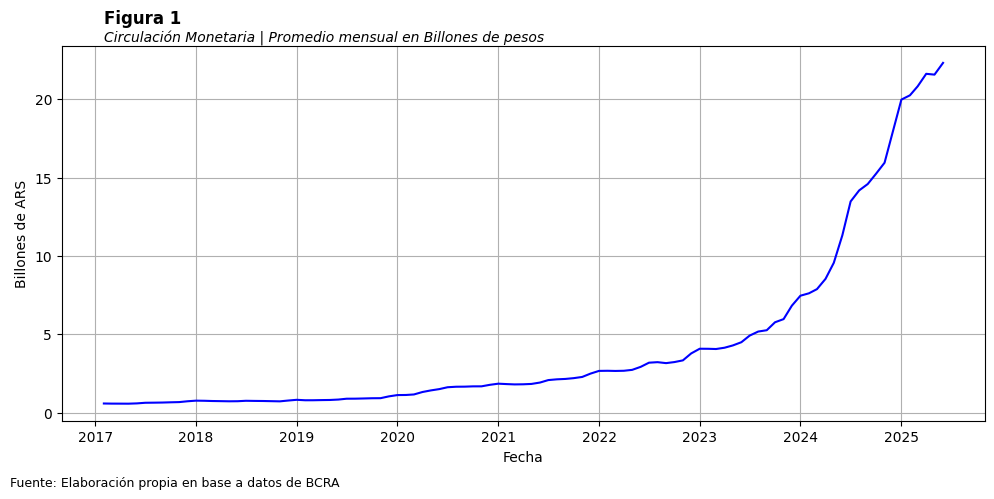

In [11]:
plt.figure(figsize=(10,5))
plt.plot(circulacion_mensual.index, circulacion_mensual.values / 1_000_000_000_000, color='blue')
plt.title('')
plt.text(x=circulacion_mensual.index.min(), y=plt.ylim()[1]*1.05,
         s="Figura 1", fontsize=12, fontweight='bold', ha='left', va='bottom')
plt.text(x=circulacion_mensual.index.min(), y=plt.ylim()[1]*1.00,
         s="Circulación Monetaria | Promedio mensual en Billones de pesos", fontsize=10,
         fontstyle='italic', ha='left', va='bottom')
plt.xlabel('Fecha')
plt.ylabel('Billones de ARS')
plt.grid(True)
plt.figtext(0.01, 0.01, "Fuente: Elaboración propia en base a datos de BCRA", fontsize=9, ha='left', va='bottom')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

**Tasa de Plazo Fijo a 30-44 días**

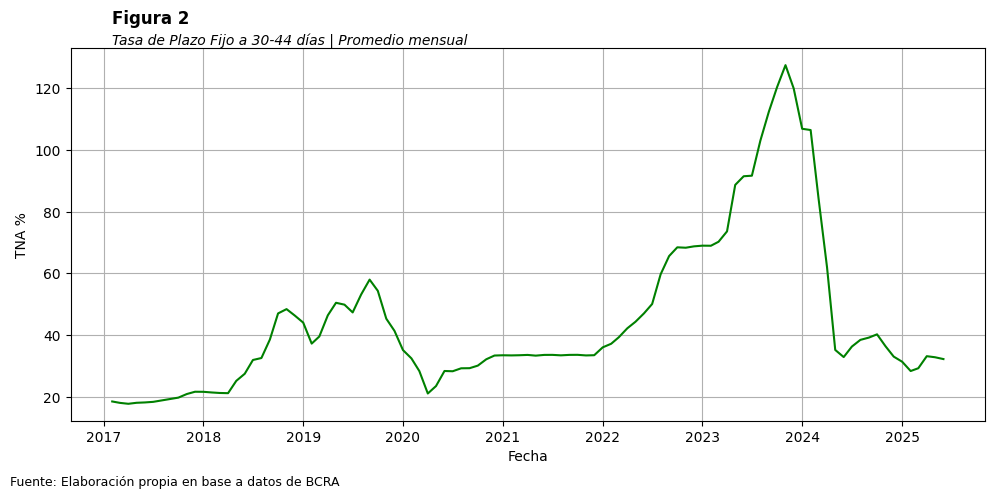

In [12]:
plt.figure(figsize=(10,5))
plt.plot(tasa_pf_mensual.index, tasa_pf_mensual.values, color='green')
plt.title('')
ylim = plt.ylim()
plt.text(x=tasa_pf_mensual.index.min(), y=ylim[1]*1.05,
         s="Figura 2", fontsize=12, fontweight='bold', ha='left', va='bottom')
plt.text(x=tasa_pf_mensual.index.min(), y=ylim[1]*1.00,
         s="Tasa de Plazo Fijo a 30-44 días | Promedio mensual", fontsize=10,
         fontstyle='italic', ha='left', va='bottom')
plt.xlabel('Fecha')
plt.ylabel('TNA %')
plt.grid(True)
plt.figtext(0.01, 0.01, "Fuente: Elaboración propia en base a datos de BCRA", fontsize=9, ha='left', va='bottom')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

**IPC Nacional**

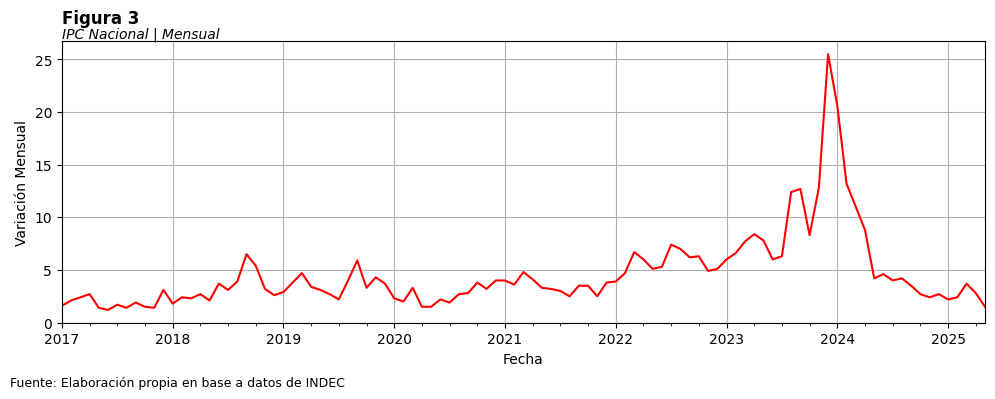

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))
ipc_mensual.plot(ax=ax, color='red', legend=False)
ax.set_title('')
ylim = ax.get_ylim()
ax.text(ipc_mensual.index.min(), ylim[1]*1.05,
        "Figura 3", fontsize=12, fontweight='bold', ha='left', va='bottom')
ax.text(ipc_mensual.index.min(), ylim[1]*1.00,
        "IPC Nacional | Mensual", fontsize=10,
        fontstyle='italic', ha='left', va='bottom')
ax.set_xlabel('Fecha')
ax.set_ylabel('Variación Mensual')
ax.grid(True)
plt.figtext(0.01, 0.01, "Fuente: Elaboración propia en base a datos de INDEC", fontsize=9, ha='left', va='bottom')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

**EMAE**


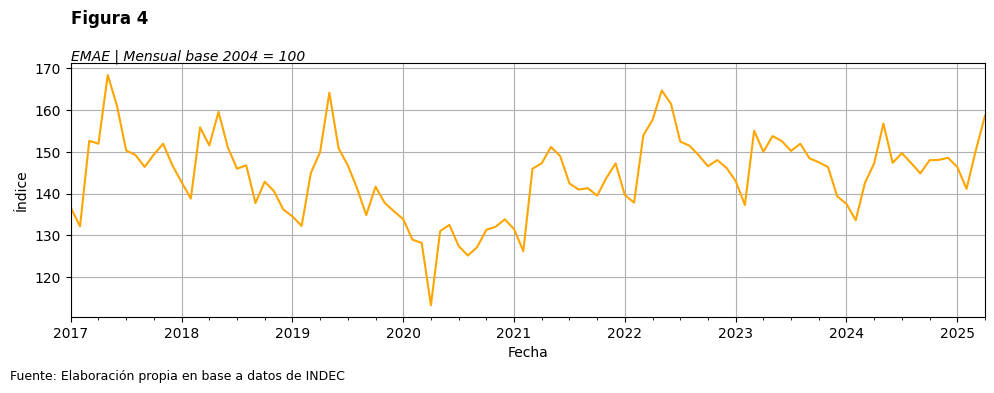

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))
emae_df.plot(ax=ax, color='orange', legend=False)
ax.set_title('')
ylim = ax.get_ylim()
ax.text(emae_df.index.min(), ylim[1]*1.05,
        "Figura 4", fontsize=12, fontweight='bold', ha='left', va='bottom')
ax.text(emae_df.index.min(), ylim[1]*1.00,
        "EMAE | Mensual base 2004 = 100", fontsize=10,
        fontstyle='italic', ha='left', va='bottom')
ax.set_xlabel('Fecha')
ax.set_ylabel('Índice')
ax.grid(True)
plt.figtext(0.01, 0.01, "Fuente: Elaboración propia en base a datos de INDEC", fontsize=9, ha='left', va='bottom')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

### Funciones de Autocovarianzas (FAS), Autocorrelación (FAC) y Autocorrelación Parcial (FACP) de las variables

In [15]:
def autocovariance(series, lag):
    series = np.asarray(series)
    n = len(series)
    mean = np.mean(series)
    if lag >= n:
        return np.nan
    return np.sum((series[:n - lag] - mean) * (series[lag:] - mean)) / (n - lag)

def autocorrelation(series, lag):
    gamma_0 = autocovariance(series, 0)
    if gamma_0 == 0:
        return np.nan
    return autocovariance(series, lag) / gamma_0

def graficar_fac_fas_facp(serie, fig_num, titulo, subtitulo, color, lags=36):
    serie = serie.dropna()
    max_lags = min(lags, len(serie) // 2 - 1)

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # FAS
    lag_range = np.arange(1, max_lags + 1)
    autocovs = [autocovariance(serie, lag) for lag in lag_range]
    axs[0].stem(lag_range, autocovs, basefmt=" ", linefmt=color, markerfmt=color)
    axs[0].set_title('FAS - Función de Autocovarianzas', fontsize=12)
    axs[0].set_xlabel('Rezago')
    axs[0].set_ylabel('Valor')
    axs[0].grid()

    # FAC
    plot_acf(serie, lags=max_lags, ax=axs[1], alpha=0.05, color=color)
    axs[1].set_title('FAC - Función de Autocorrelación', fontsize=12)
    axs[1].set_xlabel('Rezago')
    axs[1].grid()
    for line in axs[1].lines:
        line.set_color(color)
        line.set_markerfacecolor(color)
        line.set_markeredgecolor(color)
    for patch in axs[1].collections:
        patch.set_facecolor(color)
        patch.set_alpha(0.15)

    # FACP
    plot_pacf(serie, lags=max_lags, ax=axs[2], method="ywm", alpha=0.05, color=color)
    axs[2].set_title('FACP - Función de Autocorrelación Parcial', fontsize=12)
    axs[2].set_xlabel('Rezago')
    axs[2].grid()
    for line in axs[2].lines:
        line.set_color(color)
        line.set_markerfacecolor(color)
        line.set_markeredgecolor(color)
    for patch in axs[2].collections:
        patch.set_facecolor(color)
        patch.set_alpha(0.15)

    plt.suptitle(f"Figura {fig_num}", fontsize=14, fontweight='bold', x=0.01, ha='left')
    fig.text(0.015, 0.87, subtitulo, fontsize=11, fontstyle='italic', ha='left')
    plt.tight_layout(rect=[0, 0.04, 1, 0.85])
    plt.show()

**FAS, FAC y FACP de Circulación Monteria**

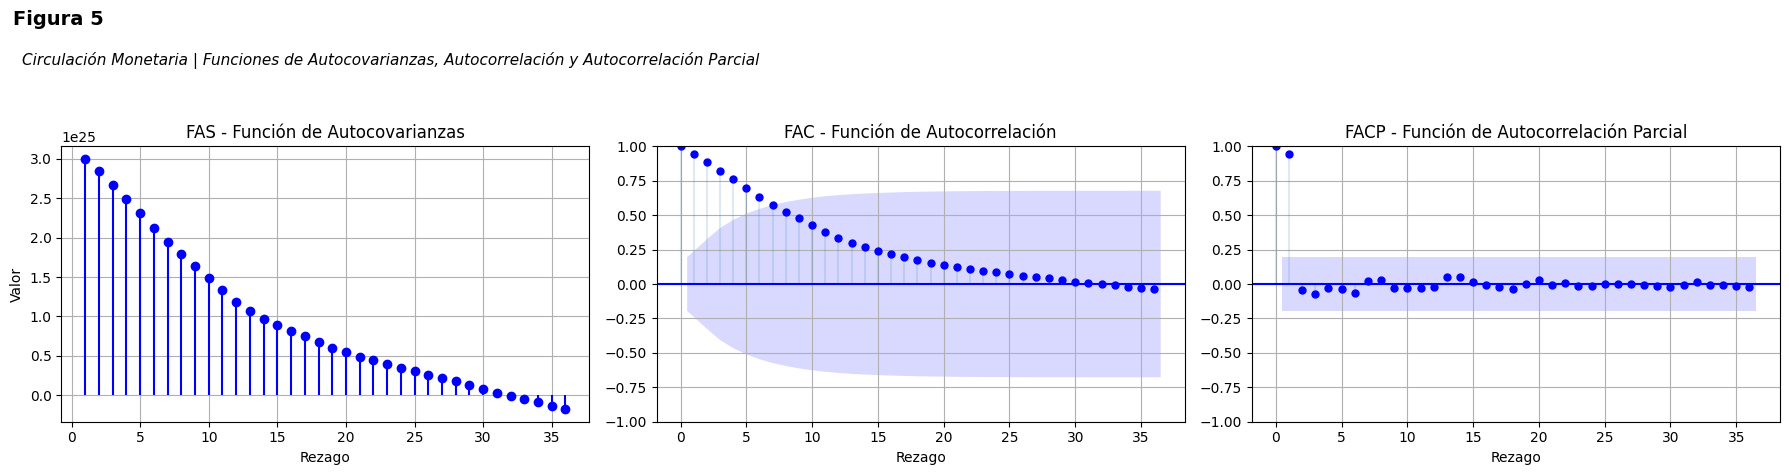

In [16]:
graficar_fac_fas_facp(
    circulacion_mensual,
    fig_num=5,
    titulo="FAC / FAS / FACP - Circulación Monetaria",
    subtitulo="Circulación Monetaria | Funciones de Autocovarianzas, Autocorrelación y Autocorrelación Parcial",
    color='blue'
)

**FAS, FAC y FACP de Tasa de Plazo Fijo a 30-44 días**

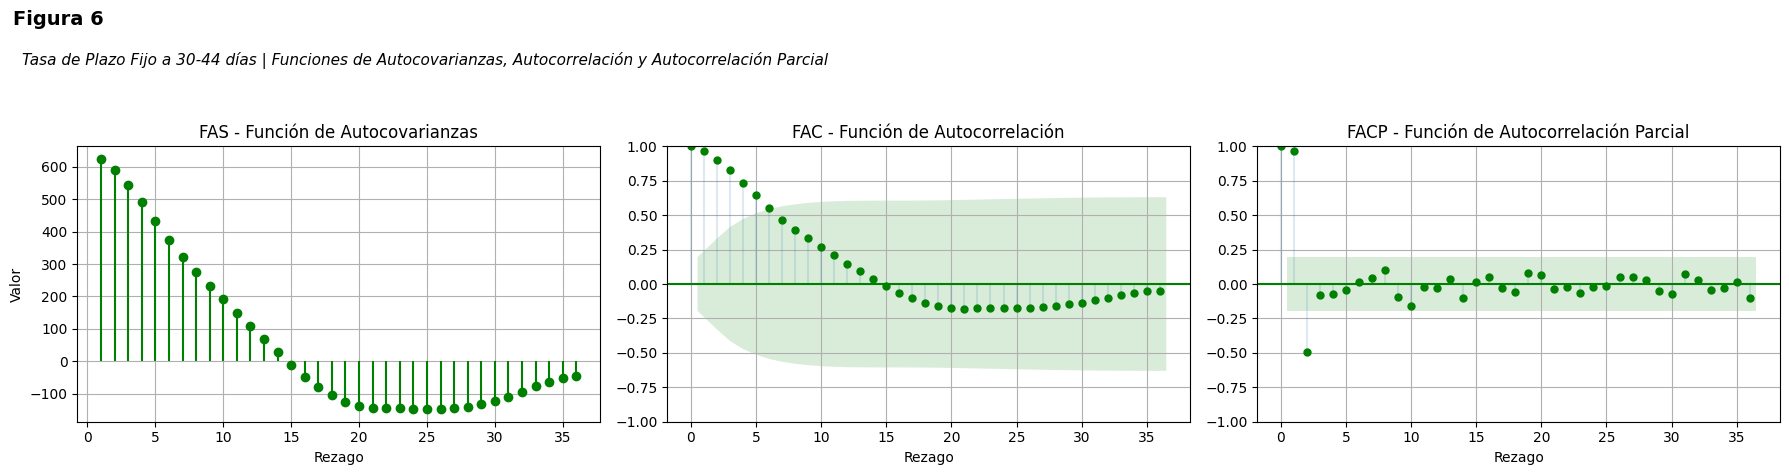

In [17]:
graficar_fac_fas_facp(
    tasa_pf_mensual,
    fig_num=6,
    titulo="FAC / FAS / FACP - Tasa de Plazo Fijo",
    subtitulo="Tasa de Plazo Fijo a 30-44 días | Funciones de Autocovarianzas, Autocorrelación y Autocorrelación Parcial",
    color='green'
)

**FAS, FAC y FACP de IPC Nacional**

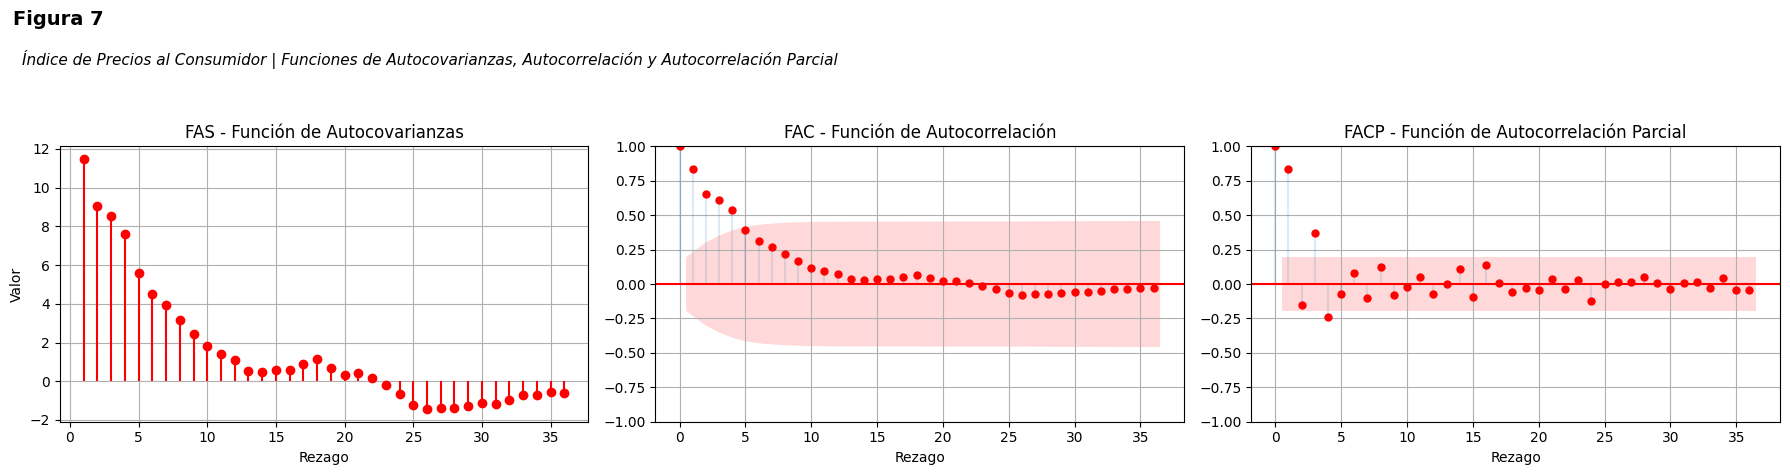

In [18]:
graficar_fac_fas_facp(
    ipc_mensual['ipc'],
    fig_num=7,
    titulo="FAC / FAS / FACP - IPC Nacional",
    subtitulo="Índice de Precios al Consumidor | Funciones de Autocovarianzas, Autocorrelación y Autocorrelación Parcial",
    color='red'
)

**FAS, FAC y FACP de Estimador Mensual de Actividad Económica**

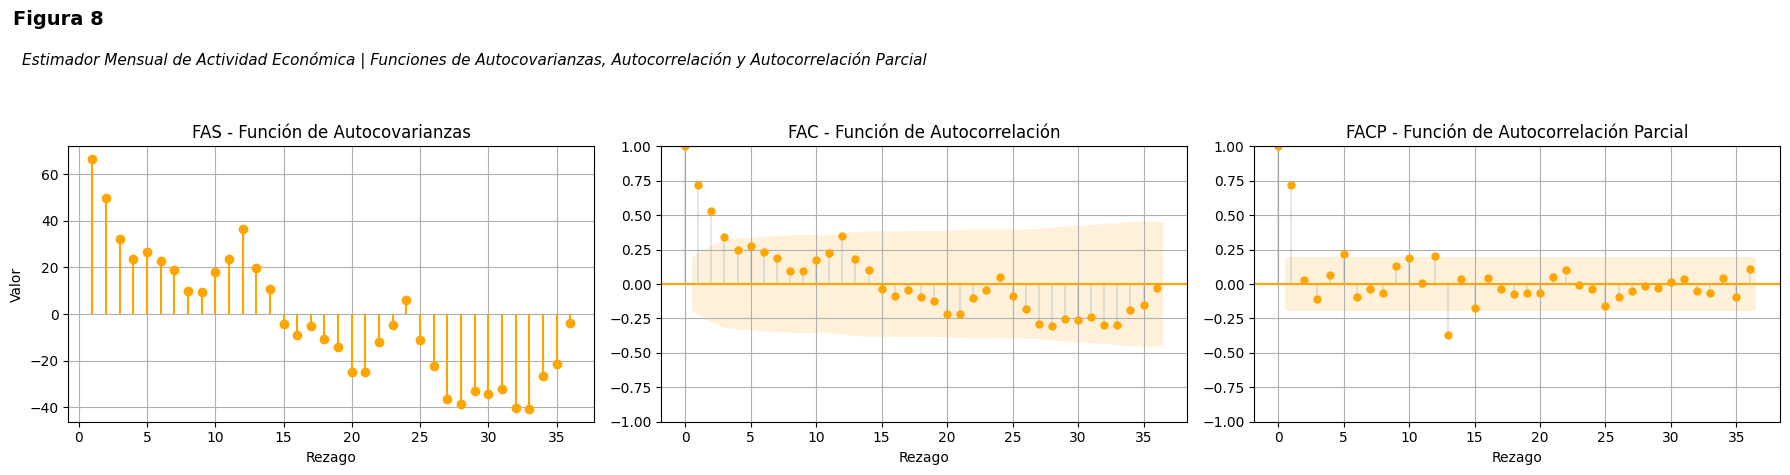

In [19]:
graficar_fac_fas_facp(
    emae_df['emae'],
    fig_num=8,
    titulo="FAC / FAS / FACP - EMAE",
    subtitulo="Estimador Mensual de Actividad Económica | Funciones de Autocovarianzas, Autocorrelación y Autocorrelación Parcial",
    color='orange'
)

### Pruebas de Raíces Unitarias.

In [20]:
def test_dickey_fuller_simple(serie):
    y = serie.dropna().values
    dy = np.diff(y)
    y_lag = y[:-1]
    X = add_constant(y_lag)
    modelo = OLS(dy, X).fit()
    stat = modelo.tvalues[1]
    crit = {'1%': -3.43, '5%': -2.86, '10%': -2.57}
    conc = 'Estacionaria' if stat < crit['5%'] else 'No Estacionaria'
    return stat, crit, conc

def test_adf(serie):
    resultado = adfuller(serie.dropna(), autolag='AIC')
    stat = resultado[0]
    pval = resultado[1]
    crit = resultado[4]
    conc = 'Estacionaria' if pval < 0.05 else 'No Estacionaria'
    return stat, pval, crit, conc

def test_kpss_test(serie):
    resultado = kpss(serie.dropna(), regression='c', nlags='auto')
    stat = resultado[0]
    pval = resultado[1]
    crit = resultado[3]
    conc = 'Estacionaria' if pval >= 0.05 else 'No Estacionaria'
    return stat, pval, crit, conc

def aplicar_tests_a_series(series_dict, nombre_columna='Variable'):
    resultados = []
    for nombre, serie in series_dict.items():
        df_stat, df_crit, df_conc = test_dickey_fuller_simple(serie)
        adf_stat, adf_p, adf_crit, adf_conc = test_adf(serie)
        kpss_stat, kpss_p, kpss_crit, kpss_conc = test_kpss_test(serie)
        resultados.append({
            nombre_columna: nombre,
            'DF estadístico': round(df_stat, 4),
            'DF 1%': df_crit['1%'], 'DF 5%': df_crit['5%'], 'DF 10%': df_crit['10%'],
            'DF conclusión': df_conc,
            'ADF estadístico': round(adf_stat, 4), 'ADF p-valor': round(adf_p, 4),
            'ADF 1%': adf_crit['1%'], 'ADF 5%': adf_crit['5%'], 'ADF 10%': adf_crit['10%'],
            'ADF conclusión': adf_conc,
            'KPSS estadístico': round(kpss_stat, 4), 'KPSS p-valor': round(kpss_p, 4),
            'KPSS 1%': kpss_crit['1%'], 'KPSS 5%': kpss_crit['5%'], 'KPSS 10%': kpss_crit['10%'],
            'KPSS conclusión': kpss_conc
        })
    return pd.DataFrame(resultados)

def reorganizar_resultados_largo(df_resultados, nombre_columna='Variable'):
    filas = []
    for _, row in df_resultados.iterrows():
        etiqueta = row[nombre_columna]
        for nivel in ['1%', '5%', '10%']:
            filas.append({
                nombre_columna: etiqueta,
                'Significancia': nivel,
                'DF estadístico': row['DF estadístico'],
                'DF crítico': row[f'DF {nivel}'],
                'DF conclusión': row['DF conclusión'],
                'ADF estadístico': row['ADF estadístico'],
                'ADF p-valor': row['ADF p-valor'],
                'ADF crítico': row[f'ADF {nivel}'],
                'ADF conclusión': row['ADF conclusión'],
                'KPSS estadístico': row['KPSS estadístico'],
                'KPSS p-valor': row['KPSS p-valor'],
                'KPSS crítico': row[f'KPSS {nivel}'],
                'KPSS conclusión': row['KPSS conclusión'],
            })
    return pd.DataFrame(filas)

def mostrar_tabla_resultados(df, titulo, nombre_columna='Variable'):
    columnas_numericas = df.select_dtypes(include='number').columns
    estilos = [
        {"selector": "caption", "props": [("caption-side", "top"), ("text-align", "left"), ("font-size", "14px")]},
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}
    ]
    styled = df.style \
        .format({col: "{:.4f}" for col in columnas_numericas}) \
        .set_table_styles(estilos) \
        .set_caption(titulo) \
        .set_properties(**{"text-align": "center"})
    return styled

In [21]:
series_originales = {
    'Circulación Monetaria': circulacion_mensual,
    'Tasa de Plazo Fijo': tasa_pf_mensual,
    'IPC Nacional': ipc_mensual['ipc'],
    'EMAE': emae_df['emae']
}

tabla1 = aplicar_tests_a_series(series_originales, nombre_columna='Variable')
tabla1_larga = reorganizar_resultados_largo(tabla1, nombre_columna='Variable')
mostrar_tabla_resultados(tabla1_larga, "<b>Tabla 1</b><br><i>Pruebas de raíces unitarias</i>", nombre_columna='Variable')

,Variable,Significancia,DF estadístico,DF crítico,DF conclusión,ADF estadístico,ADF p-valor,ADF crítico,ADF conclusión,KPSS estadístico,KPSS p-valor,KPSS crítico,KPSS conclusión
0,Circulación Monetaria,1%,8.3817,-3.4300,No Estacionaria,2.7310,0.9991,-3.5079,No Estacionaria,1.1952,0.0100,0.7390,No Estacionaria
1,Circulación Monetaria,5%,8.3817,-2.8600,No Estacionaria,2.7310,0.9991,-2.8954,No Estacionaria,1.1952,0.0100,0.4630,No Estacionaria
2,Circulación Monetaria,10%,8.3817,-2.5700,No Estacionaria,2.7310,0.9991,-2.5848,No Estacionaria,1.1952,0.0100,0.3470,No Estacionaria
3,Tasa de Plazo Fijo,1%,-1.3247,-3.4300,No Estacionaria,-2.3915,0.1442,-3.4982,No Estacionaria,0.6137,0.0214,0.7390,No Estacionaria
4,Tasa de Plazo Fijo,5%,-1.3247,-2.8600,No Estacionaria,-2.3915,0.1442,-2.8912,No Estacionaria,0.6137,0.0214,0.4630,No Estacionaria
5,Tasa de Plazo Fijo,10%,-1.3247,-2.5700,No Estacionaria,-2.3915,0.1442,-2.5826,No Estacionaria,0.6137,0.0214,0.3470,No Estacionaria
6,IPC Nacional,1%,-2.9072,-3.4300,Estacionaria,-2.5708,0.0992,-3.4996,No Estacionaria,0.6097,0.0218,0.7390,No Estacionaria
7,IPC Nacional,5%,-2.9072,-2.8600,Estacionaria,-2.5708,0.0992,-2.8918,No Estacionaria,0.6097,0.0218,0.4630,No Estacionaria
8,IPC Nacional,10%,-2.9072,-2.5700,Estacionaria,-2.5708,0.0992,-2.5829,No Estacionaria,0.6097,0.0218,0.3470,No Estacionaria
9,EMAE,1%,-3.7898,-3.4300,Estacionaria,-1.8420,0.3598,-3.5079,No Estacionaria,0.2306,0.1000,0.7390,Estacionaria


**Raíces Unitarias con Estacionalidad mediante test de HEGY**

In [22]:
serie = circulacion_mensual

def construir_hegy_vars(x, s=6):
    x_lag1 = x.shift(1)
    signos = np.array([(-1)**t for t in range(len(x))])
    x_lag1_alt = x_lag1 * signos
    x_lag2 = x.shift(2)
    lambdas = [2 * np.pi * j / s for j in [1, 2]]
    Z1 = 2 * np.cos(lambdas[0]) * x_lag1 - x_lag2
    W1 = x_lag1 - 2 * np.cos(lambdas[0]) * x_lag2
    Z2 = 2 * np.cos(lambdas[1]) * x_lag1 - x_lag2
    W2 = x_lag1 - 2 * np.cos(lambdas[1]) * x_lag2

    df_hegy = pd.DataFrame({
        'x_lag1': x_lag1,
        'x_lag1_alt': x_lag1_alt,
        'Z1': Z1,
        'W1': W1,
        'Z2': Z2,
        'W2': W2,
    })

    return df_hegy

hegy_vars = construir_hegy_vars(serie, s=6)

y_diff = serie - serie.shift(6)
df_reg = pd.concat([y_diff, hegy_vars], axis=1).dropna()
Y = df_reg.iloc[:, 0]
X = df_reg.iloc[:, 1:]
X = sm.add_constant(X)

modelo = sm.OLS(Y, X).fit()
print(modelo.summary())

                              OLS Regression Results                             
Dep. Variable:     circulacion_monetaria   R-squared:                       0.931
Model:                               OLS   Adj. R-squared:                  0.929
Method:                    Least Squares   F-statistic:                     410.4
Date:                   Tue, 15 Jul 2025   Prob (F-statistic):           9.71e-53
Time:                           18:32:16   Log-Likelihood:                -2699.5
No. Observations:                     95   AIC:                             5407.
Df Residuals:                         91   BIC:                             5417.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.171e+11 

### Modelos para estimar la variable Circulación Monetaria

### Transformaciones propuestas

**Diferenciación regular**



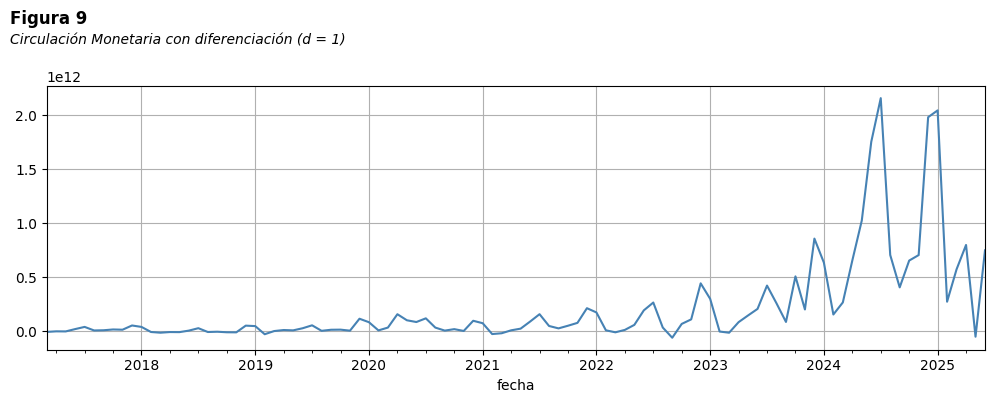

In [23]:
serie_diff = serie.diff().dropna()

fig, ax = plt.subplots(figsize=(10, 4))
serie_diff.plot(ax=ax, color='steelblue')
ax.grid(True)
fig.text(0.01, 0.96, "Figura 9", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91, "Circulación Monetaria con diferenciación (d = 1)", fontsize=10, style='italic', ha='left')
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

**Diferenciación estacional**

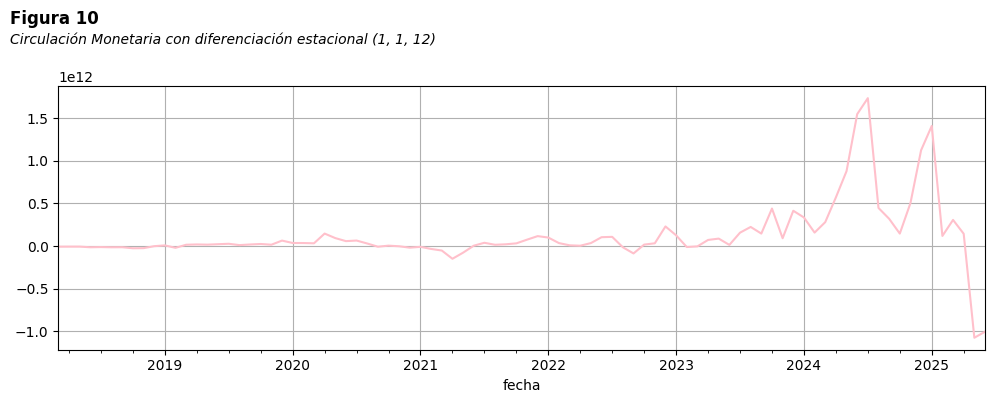

In [24]:
serie_diff_seasonal = serie_diff.diff(12).dropna()

fig, ax = plt.subplots(figsize=(10, 4))
serie_diff_seasonal.plot(ax=ax, color='pink')
ax.grid(True)
fig.text(0.01, 0.96, "Figura 10", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91, "Circulación Monetaria con diferenciación estacional (1, 1, 12)", fontsize=10, style='italic', ha='left')
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

**Transformación logarítmica**

In [25]:
serie_log = np.log(serie)

**Diferencias regular de la transformación logarítmica**


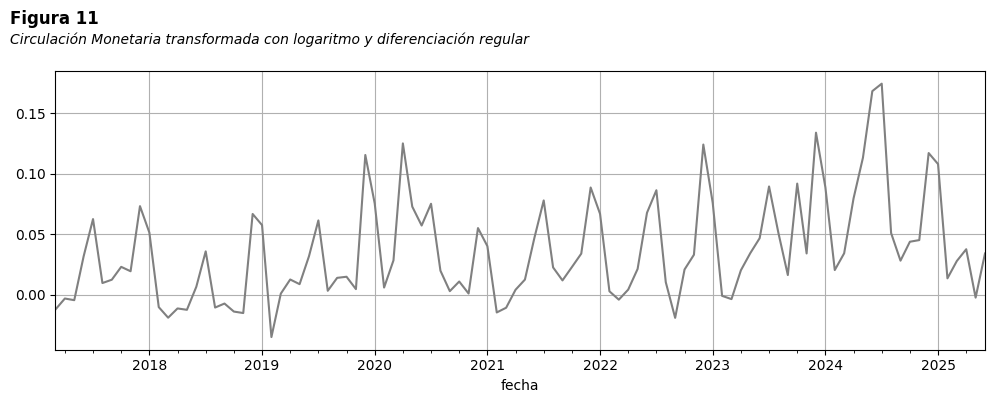

In [26]:
serie_log_diff1 = serie_log.diff().dropna()

fig, ax = plt.subplots(figsize=(10, 4))
serie_log_diff1.plot(ax=ax, color='gray')
ax.grid(True)
fig.text(0.01, 0.96, "Figura 11", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91, "Circulación Monetaria transformada con logaritmo y diferenciación regular", fontsize=10, style='italic', ha='left')
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

**Diferencias estacional (1, 1, 6) de la transformación logarítmica**


In [27]:
serie_log_diff_seasonal_6 = serie_log_diff1.diff(6).dropna()

serie_log_diff_seasonal_6.plot(ax=ax, color='black')
ax.grid(True)
fig.text(0.01, 0.96, "Figura 12", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91, "Circulación Monetaria transformada con logaritmo y diferenciación estacional (1, 1, 6)", fontsize=10, style='italic', ha='left')
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

<Figure size 640x480 with 0 Axes>

**Diferencias estacional (1, 1, 12) de la transformación logarítmica**


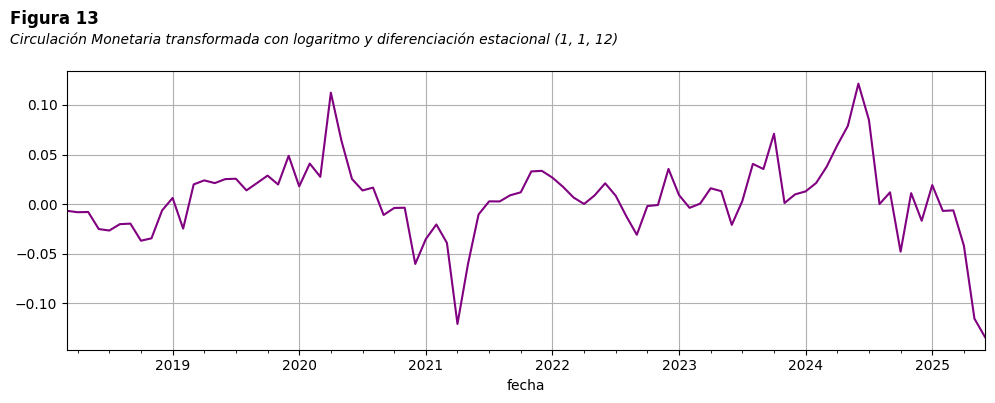

In [28]:
serie_log_diff_seasonal = serie_log_diff1.diff(12).dropna()

fig, ax = plt.subplots(figsize=(10, 4))
serie_log_diff_seasonal.plot(ax=ax, color='purple')
ax.grid(True)
fig.text(0.01, 0.96, "Figura 13", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91, "Circulación Monetaria transformada con logaritmo y diferenciación estacional (1, 1, 12)", fontsize=10, style='italic', ha='left')
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

### Tests de raíces unitarias para series transformadas

In [29]:
series_transformadas = {
    'Diferenciación Regular (d=1)': serie_diff,
    'Diferenciación Estacional (1, 1, 12)': serie_diff_seasonal,
    'Log + Diferenciación Regular': serie_log_diff1,
    'Log + Diferenciación Estacional (1, 1, 6)': serie_log_diff_seasonal_6,
    'Log + Diferenciación Estacional (1, 1, 12)': serie_log_diff_seasonal
}

tabla2 = aplicar_tests_a_series(series_transformadas, nombre_columna='Transformación')
tabla2_larga = reorganizar_resultados_largo(tabla2, nombre_columna='Transformación')
mostrar_tabla_resultados(tabla2_larga, "<b>Tabla 2</b><br><i>Tests de raíces unitarias para series transformadas</i>", nombre_columna='Transformación')

,Transformación,Significancia,DF estadístico,DF crítico,DF conclusión,ADF estadístico,ADF p-valor,ADF crítico,ADF conclusión,KPSS estadístico,KPSS p-valor,KPSS crítico,KPSS conclusión
0,Diferenciación Regular (d=1),1%,-4.1064,-3.4300,Estacionaria,-5.6720,0.0000,-3.5079,Estacionaria,1.0296,0.0100,0.7390,No Estacionaria
1,Diferenciación Regular (d=1),5%,-4.1064,-2.8600,Estacionaria,-5.6720,0.0000,-2.8954,Estacionaria,1.0296,0.0100,0.4630,No Estacionaria
2,Diferenciación Regular (d=1),10%,-4.1064,-2.5700,Estacionaria,-5.6720,0.0000,-2.5848,Estacionaria,1.0296,0.0100,0.3470,No Estacionaria
3,"Diferenciación Estacional (1, 1, 12)",1%,-3.1004,-3.4300,Estacionaria,-4.8749,0.0000,-3.5183,Estacionaria,0.4941,0.0430,0.7390,No Estacionaria
4,"Diferenciación Estacional (1, 1, 12)",5%,-3.1004,-2.8600,Estacionaria,-4.8749,0.0000,-2.8999,Estacionaria,0.4941,0.0430,0.4630,No Estacionaria
5,"Diferenciación Estacional (1, 1, 12)",10%,-3.1004,-2.5700,Estacionaria,-4.8749,0.0000,-2.5872,Estacionaria,0.4941,0.0430,0.3470,No Estacionaria
6,Log + Diferenciación Regular,1%,-6.0191,-3.4300,Estacionaria,-2.5167,0.1115,-3.5079,No Estacionaria,0.9319,0.0100,0.7390,No Estacionaria
7,Log + Diferenciación Regular,5%,-6.0191,-2.8600,Estacionaria,-2.5167,0.1115,-2.8954,No Estacionaria,0.9319,0.0100,0.4630,No Estacionaria
8,Log + Diferenciación Regular,10%,-6.0191,-2.5700,Estacionaria,-2.5167,0.1115,-2.5848,No Estacionaria,0.9319,0.0100,0.3470,No Estacionaria
9,"Log + Diferenciación Estacional (1, 1, 6)",1%,-6.0357,-3.4300,Estacionaria,-3.5667,0.0064,-3.5127,Estacionaria,0.0778,0.1000,0.7390,Estacionaria


### Estimación de los coeficientes de los modelos y análisis de diagnóstico de los residuos

Separación de datos de entrenamiento.

- Meses de prueba: últimos 12.
- Meses de entrenamiento: Todos los anteriores.

In [30]:
n_test = 12
train = serie_log.iloc[:-n_test]
test = serie_log.iloc[-n_test:]

Modelo SARIMA con diferenciación regular y estacional semestral sobre la serie logarítmica.

In [31]:
modelo1 = sm.tsa.SARIMAX(
    train,
    order=(0, 1, 1),
    seasonal_order=(1, 1, 1, 6),
    enforce_stationarity=False,
    enforce_invertibility=False
)

resultado_6 = modelo1.fit(disp=False)
resid_6 = resultado_6.resid
resid_std_6 = (resid_6 - resid_6.mean()) / resid_6.std()
print(resultado_6.summary())

                                     SARIMAX Results                                     
Dep. Variable:             circulacion_monetaria   No. Observations:                   89
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 6)   Log Likelihood                 160.290
Date:                           Tue, 15 Jul 2025   AIC                           -312.579
Time:                                   18:33:26   BIC                           -303.363
Sample:                               02-01-2017   HQIC                          -308.903
                                    - 06-01-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4909      0.124      3.948      0.000       0.247       0.735
ar.S.L6       -0.4520      0.128     -3.536

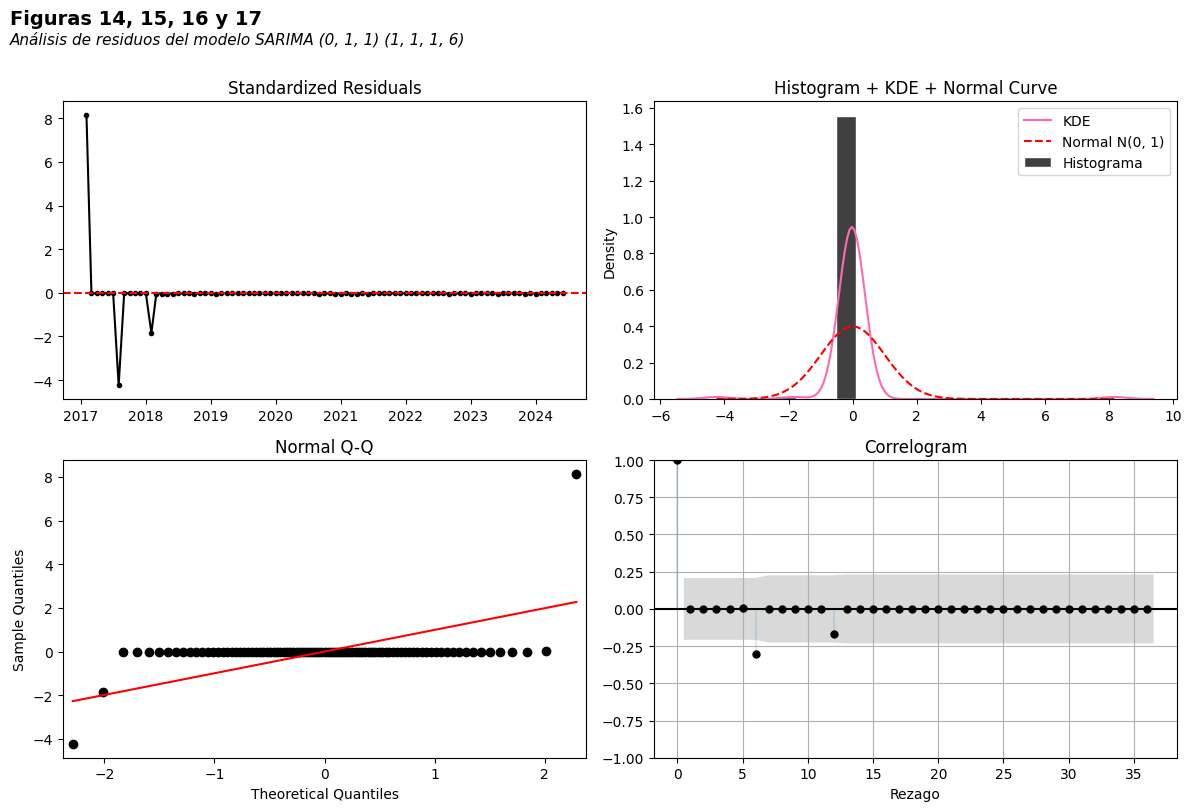

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Standardized Residuals
axes[0, 0].plot(resid_std_6, color='black', marker='o', markersize=3)
axes[0, 0].axhline(y=0, linestyle='--', color='red')
axes[0, 0].set_title("Standardized Residuals", color='black')
axes[0, 0].tick_params(colors='black')

# Histogram
sns.histplot(
    resid_std_6,
    bins=20,
    kde=False,
    color='black',
    edgecolor='white',
    stat="density",
    ax=axes[0, 1],
    label='Histograma'
)
sns.kdeplot(
    resid_std_6,
    color='hotpink',
    ax=axes[0, 1],
    label='KDE'
)
x = np.linspace(resid_std_6.min(), resid_std_6.max(), 100)
axes[0, 1].plot(
    x,
    norm.pdf(x, 0, 1),
    color='red',
    linestyle='--',
    label='Normal N(0, 1)'
)
axes[0, 1].set_title("Histogram + KDE + Normal Curve", color='black')
axes[0, 1].legend()
axes[0, 1].tick_params(colors='black')

# Q-Q Plot
qq = qqplot(resid_std_6, line='s', ax=axes[1, 0])
if axes[1, 0].collections:
    dots = axes[1, 0].collections[0]
    dots.set_facecolor('black')
    dots.set_edgecolor('black')
elif len(axes[1, 0].lines) > 1:
    puntos = axes[1, 0].lines[0]
    puntos.set_color('black')
    puntos.set_markerfacecolor('black')
    puntos.set_markeredgecolor('black')
if len(axes[1, 0].lines) > 1:
    linea_teorica = axes[1, 0].lines[1]
    linea_teorica.set_color('red')
axes[1, 0].set_title("Normal Q-Q", color='black')
axes[1, 0].tick_params(colors='black')

# Correlograma
color = 'black'
max_lags = 36
plot_acf(resid_std_6, ax=axes[1, 1], lags=max_lags, alpha=0.05, color=color)
axes[1, 1].set_title('Correlogram', fontsize=12, color=color)
axes[1, 1].set_xlabel('Rezago')
axes[1, 1].grid(True)
for line in axes[1, 1].lines:
    line.set_color(color)
    line.set_markerfacecolor(color)
    line.set_markeredgecolor(color)
for patch in axes[1, 1].collections:
    patch.set_facecolor(color)
    patch.set_alpha(0.15)
axes[1, 1].tick_params(colors=color)

fig.text(0.01, 0.99, "Figuras 14, 15, 16 y 17", fontsize=14, fontweight='bold', color='black', ha='left')
fig.text(0.01, 0.965, "Análisis de residuos del modelo SARIMA (0, 1, 1) (1, 1, 1, 6)", fontsize=11, style='italic', color='black', ha='left')
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

Modelo SARIMA con diferenciación regular y estacional anual sobre la serie logarítmica.

In [33]:
modelo2 = sm.tsa.SARIMAX(
    train,
    order=(0, 1, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

resultado_12 = modelo2.fit(disp=False)
resid_12 = resultado_12.resid
resid_std_12 = (resid_12 - resid_12.mean()) / resid_12.std()
print(resultado_12.summary())

                                     SARIMAX Results                                      
Dep. Variable:              circulacion_monetaria   No. Observations:                   89
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 132.252
Date:                            Tue, 15 Jul 2025   AIC                           -258.505
Time:                                    18:33:45   BIC                           -252.123
Sample:                                02-01-2017   HQIC                          -255.999
                                     - 06-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5437      0.123      4.409      0.000       0.302       0.785
ma.S.L12      -0.5557      0.147   

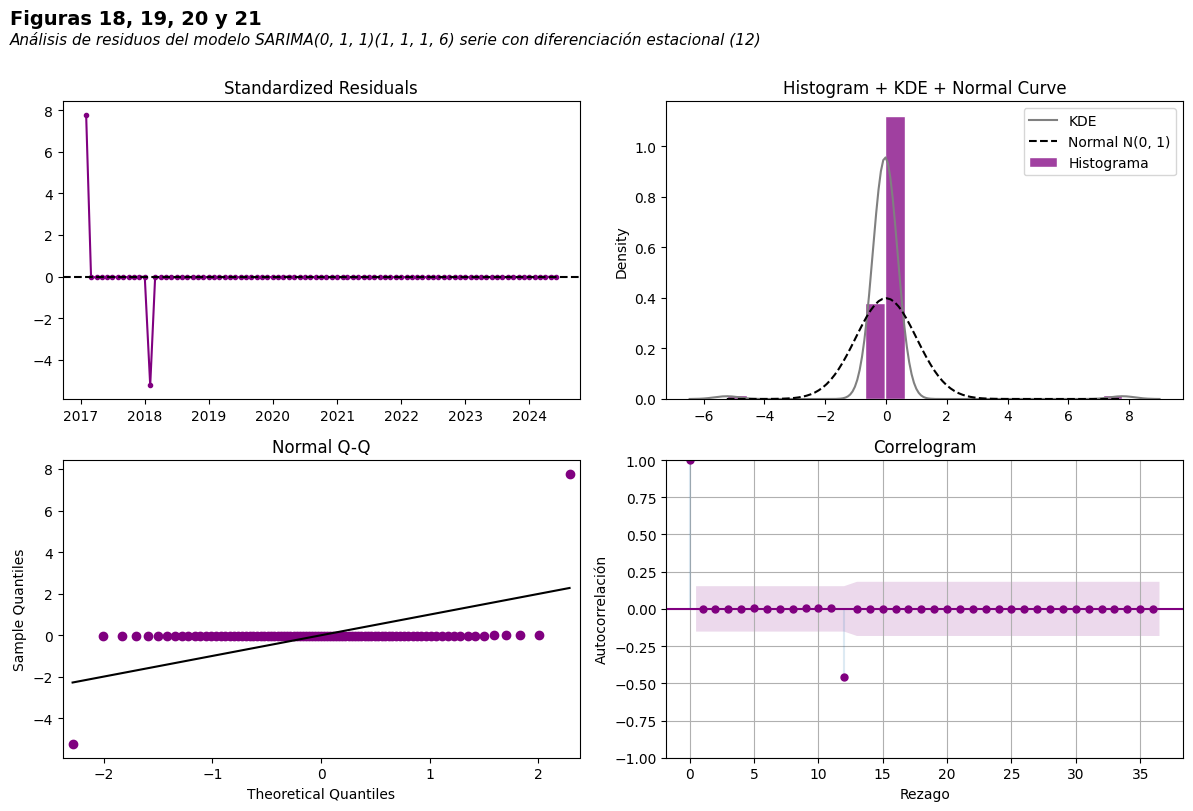

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Standardized Residuals
axes[0, 0].plot(resid_std_12, color='purple', marker='o', markersize=3)
axes[0, 0].axhline(y=0, linestyle='--', color='black')
axes[0, 0].set_title("Standardized Residuals", color='black')
axes[0, 0].tick_params(colors='black')

# Histogram
sns.histplot(
    resid_std_12,
    bins=20,
    kde=False,
    color='purple',
    edgecolor='white',
    stat="density",
    ax=axes[0, 1],
    label='Histograma'
)
sns.kdeplot(
    resid_std_12,
    color='gray',
    ax=axes[0, 1],
    label='KDE'
)
x = np.linspace(resid_std_12.min(), resid_std_12.max(), 100)
axes[0, 1].plot(
    x,
    norm.pdf(x, 0, 1),
    color='black',
    linestyle='--',
    label='Normal N(0, 1)'
)
axes[0, 1].set_title("Histogram + KDE + Normal Curve", color='black')
axes[0, 1].legend()
axes[0, 1].tick_params(colors='black')

# Q-Q Plot
qq = qqplot(resid_std_12, line='s', ax=axes[1, 0])
if axes[1, 0].collections:
    dots = axes[1, 0].collections[0]
    dots.set_facecolor('purple')
    dots.set_edgecolor('purple')
elif len(axes[1, 0].lines) > 1:
    puntos = axes[1, 0].lines[0]
    puntos.set_color('purple')
    puntos.set_markerfacecolor('purple')
    puntos.set_markeredgecolor('purple')
if len(axes[1, 0].lines) > 1:
    linea_teorica = axes[1, 0].lines[1]
    linea_teorica.set_color('black')
axes[1, 0].set_title("Normal Q-Q", color='black')
axes[1, 0].tick_params(colors='black')

# Correlograma
color_lineas = 'purple'
color_textos = 'black'
max_lags = 36
plot_acf(resid_std_12, ax=axes[1, 1], lags=max_lags, alpha=0.15, color=color_lineas, title='')
axes[1, 1].set_title('Correlogram', fontsize=12, color=color_textos)
axes[1, 1].set_xlabel('Rezago', color=color_textos)
axes[1, 1].set_ylabel('Autocorrelación', color=color_textos)
axes[1, 1].grid(True)

for line in axes[1, 1].lines:
    line.set_color(color_lineas)
    line.set_markerfacecolor(color_lineas)
    line.set_markeredgecolor(color_lineas)
for patch in axes[1, 1].collections:
    patch.set_facecolor(color_lineas)
    patch.set_alpha(0.15)
axes[1, 1].tick_params(colors=color_textos)

fig.text(0.01, 0.99, "Figuras 18, 19, 20 y 21", fontsize=14, fontweight='bold', color='black', ha='left')
fig.text(0.01, 0.965, "Análisis de residuos del modelo SARIMA(0, 1, 1)(1, 1, 1, 6) serie con diferenciación estacional (12)", fontsize=11, style='italic', color='black', ha='left')

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

### Pronóstico a partir del modelo seleccionado y comparación con otros modelos

In [35]:
n_test = len(test)
test_original = np.exp(test)

Modelo SARIMA (0, 1, 1) (1, 1, 1, 6).


In [36]:
pred_6 = resultado_6.get_forecast(steps=n_test)
pred_mean_log_6 = pred_6.predicted_mean
pred_std_log_6 = pred_6.se_mean
pred_ci_log_6 = pred_6.conf_int()

pred_mean_6 = np.exp(pred_mean_log_6)
pred_ci_6 = np.exp(pred_ci_log_6)

pred_upper_1sd = np.exp(pred_mean_log_6 + pred_std_log_6)
pred_lower_1sd = np.exp(pred_mean_log_6 - pred_std_log_6)
pred_upper_2sd = np.exp(pred_mean_log_6 + 2 * pred_std_log_6)
pred_lower_2sd = np.exp(pred_mean_log_6 - 2 * pred_std_log_6)

In [37]:
mse_6 = mean_squared_error(test_original, pred_mean_6)
rmse_6 = np.sqrt(mse_6)
mae_6 = mean_absolute_error(test_original, pred_mean_6)
mape_6 = np.mean(np.abs((test_original - pred_mean_6) / test_original)) * 100

print(f"📉 RMSE (escala original): $ {rmse_6:,.0f}")
print(f"📉 MAE  (escala original): $ {mae_6:,.0f}")
print(f"📉 MAPE (escala original): {mape_6:.2f}%")

📉 RMSE (escala original): $ 1,543,616,752,305
📉 MAE  (escala original): $ 1,418,923,817,818
📉 MAPE (escala original): 7.79%


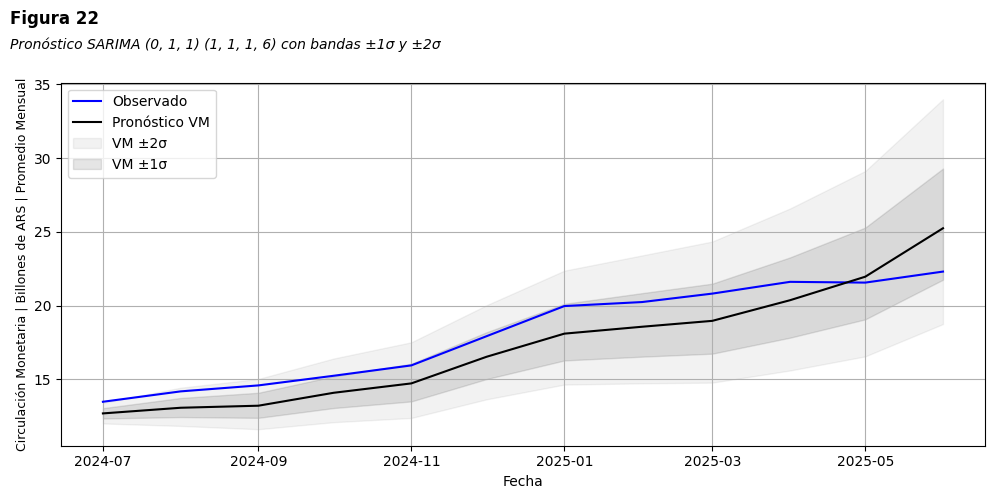

In [38]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ax.plot(test_original.index, test_original, label='Observado', color='blue')
ax.plot(pred_mean_6.index, pred_mean_6, label='Pronóstico VM', color='black')
ax.fill_between(test_original.index, pred_lower_2sd, pred_upper_2sd,
                color='black', alpha=0.05, label='VM ±2σ')
ax.fill_between(test_original.index, pred_lower_1sd, pred_upper_1sd,
                color='black', alpha=0.10, label='VM ±1σ')
ax.set_xlabel("Fecha")
ax.set_ylabel("Circulación Monetaria | Billones de ARS | Promedio Mensual", fontsize=9)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x / 1e12)}'))
ax.legend()
ax.grid(True)

fig.text(0.01, 0.96, "Figura 22", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91, "Pronóstico SARIMA (0, 1, 1) (1, 1, 1, 6) con bandas ±1σ y ±2σ",
         fontsize=10, style='italic', ha='left')

plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

Modelo SARIMA (0, 1, 1) (0, 1, 1, 12).


In [39]:
pred_12 = resultado_12.get_forecast(steps=n_test)
pred_mean_log_12 = pred_12.predicted_mean
pred_std_log_12 = pred_12.se_mean
pred_ci_log_12 = pred_12.conf_int()

pred_mean_12 = np.exp(pred_mean_log_12)
pred_ci_12 = np.exp(pred_ci_log_12)

pred_upper_1sd = np.exp(pred_mean_log_12 + pred_std_log_12)
pred_lower_1sd = np.exp(pred_mean_log_12 - pred_std_log_12)
pred_upper_2sd = np.exp(pred_mean_log_12 + 2 * pred_std_log_12)
pred_lower_2sd = np.exp(pred_mean_log_12 - 2 * pred_std_log_12)

In [40]:
mse_12 = mean_squared_error(test_original, pred_mean_12)
rmse_12 = np.sqrt(mse_12)
mae_12 = mean_absolute_error(test_original, pred_mean_12)
mape_12 = np.mean(np.abs((test_original - pred_mean_12) / test_original)) * 100

print(f"📉 RMSE (escala original): $ {rmse_12:,.0f}")
print(f"📉 MAE  (escala original): $ {mae_12:,.0f}")
print(f"📉 MAPE (escala original): {mape_12:.2f}%")

📉 RMSE (escala original): $ 1,875,118,184,716
📉 MAE  (escala original): $ 1,658,585,862,741
📉 MAPE (escala original): 8.96%


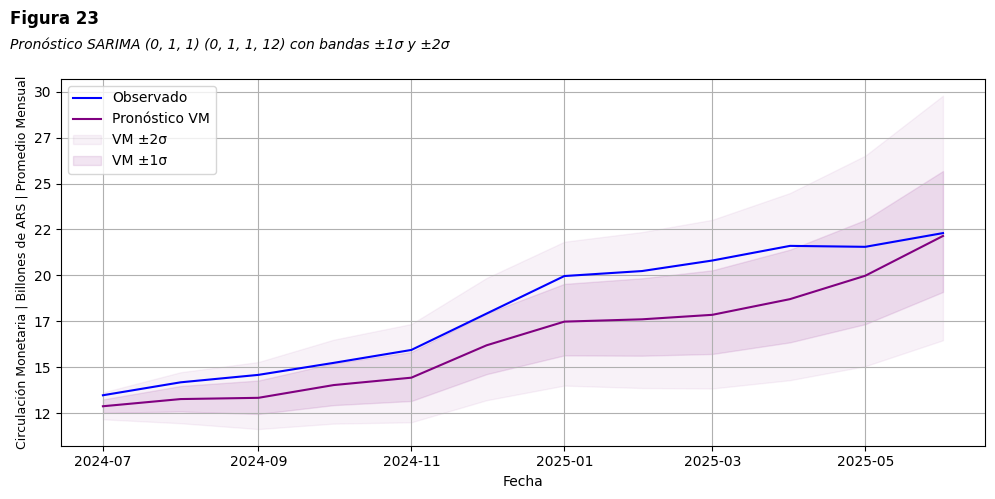

In [41]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ax.plot(test_original.index, test_original, label='Observado', color='blue')
ax.plot(pred_mean_12.index, pred_mean_12, label='Pronóstico VM', color='purple')
ax.fill_between(test_original.index, pred_lower_2sd, pred_upper_2sd,
                color='purple', alpha=0.05, label='VM ±2σ')
ax.fill_between(test_original.index, pred_lower_1sd, pred_upper_1sd,
                color='purple', alpha=0.10, label='VM ±1σ')
ax.set_xlabel("Fecha")
ax.set_ylabel("Circulación Monetaria | Billones de ARS | Promedio Mensual", fontsize=9)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x / 1e12)}'))
ax.legend()
ax.grid(True)

fig.text(0.01, 0.96, "Figura 23", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91, "Pronóstico SARIMA (0, 1, 1) (0, 1, 1, 12) con bandas ±1σ y ±2σ",
         fontsize=10, style='italic', ha='left')

plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

In [42]:
resultados_modelos = pd.DataFrame([
    {
        "Modelo": "SARIMA (0, 1, 1) (1, 1, 1, 6)",
        "RMSE": f"$ {rmse_6:,.0f}",
        "MAE": f"$ {mae_6:,.0f}",
        "MAPE (%)": f"{mape_6:.2f}%"
    },
    {
        "Modelo": "SARIMA (0, 1, 1) (0, 1, 1, 12)",
        "RMSE": f"$ {rmse_12:,.0f}",
        "MAE": f"$ {mae_12:,.0f}",
        "MAPE (%)": f"{mape_12:.2f}%"
    }
])

mostrar_tabla_resultados(
    resultados_modelos,
    "<b>Tabla 3</b><br><i>Comparación de desempeño de modelos SARIMA</i>",
    nombre_columna="Modelo"
)

,Modelo,RMSE,MAE,MAPE (%)
0,"SARIMA (0, 1, 1) (1, 1, 1, 6)","$ 1,543,616,752,305","$ 1,418,923,817,818",7.79%
1,"SARIMA (0, 1, 1) (0, 1, 1, 12)","$ 1,875,118,184,716","$ 1,658,585,862,741",8.96%


### Modelo SARIMA-X

Transformaciones necesarias para contar con todas las variables para el modelo.

In [43]:
y = serie_log
log_tasa = np.log(tasa_pf_mensual)
log_ipc = np.log(ipc_mensual['ipc'])
log_emae = np.log(emae_df['emae'])

X = pd.concat([
    log_tasa,
    log_ipc,
    log_emae
], axis=1)
X.columns = ['tasa_pf', 'ipc', 'emae']
y, X = y.align(X, join='inner')

Separación de datos de entrenamiento.

- Meses de prueba: últimos 12.
- Meses de entrenamiento: Todos los anteriores.


In [44]:
n_test = 12
y_train, y_test = y.iloc[:-n_test], y.iloc[-n_test:]
X_train, X_test = X.iloc[:-n_test], X.iloc[-n_test:]

Entrenamiento del modelo y estimación de sus coeficientes.

In [45]:
modelo_sarimax = sm.tsa.SARIMAX(
    y_train,
    exog=X_train,
    order=(0, 1, 1),
    seasonal_order=(1, 1, 1, 6),
    enforce_stationarity=False,
    enforce_invertibility=False
)

resultado_sarimax = modelo_sarimax.fit(disp=False)
resid_sarimax = resultado_sarimax.resid
resid_std_sarimax = (resid_sarimax - resid_sarimax.mean()) / resid_sarimax.std()

print(resultado_sarimax.summary())

                                     SARIMAX Results                                     
Dep. Variable:             circulacion_monetaria   No. Observations:                   89
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 6)   Log Likelihood                 165.938
Date:                           Tue, 15 Jul 2025   AIC                           -317.877
Time:                                   18:35:20   BIC                           -301.748
Sample:                               02-01-2017   HQIC                          -311.443
                                    - 06-01-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tasa_pf       -0.0860      0.036     -2.396      0.017      -0.156      -0.016
ipc           -0.0047      0.011     -0.429

Diagnóstico de los residuos.

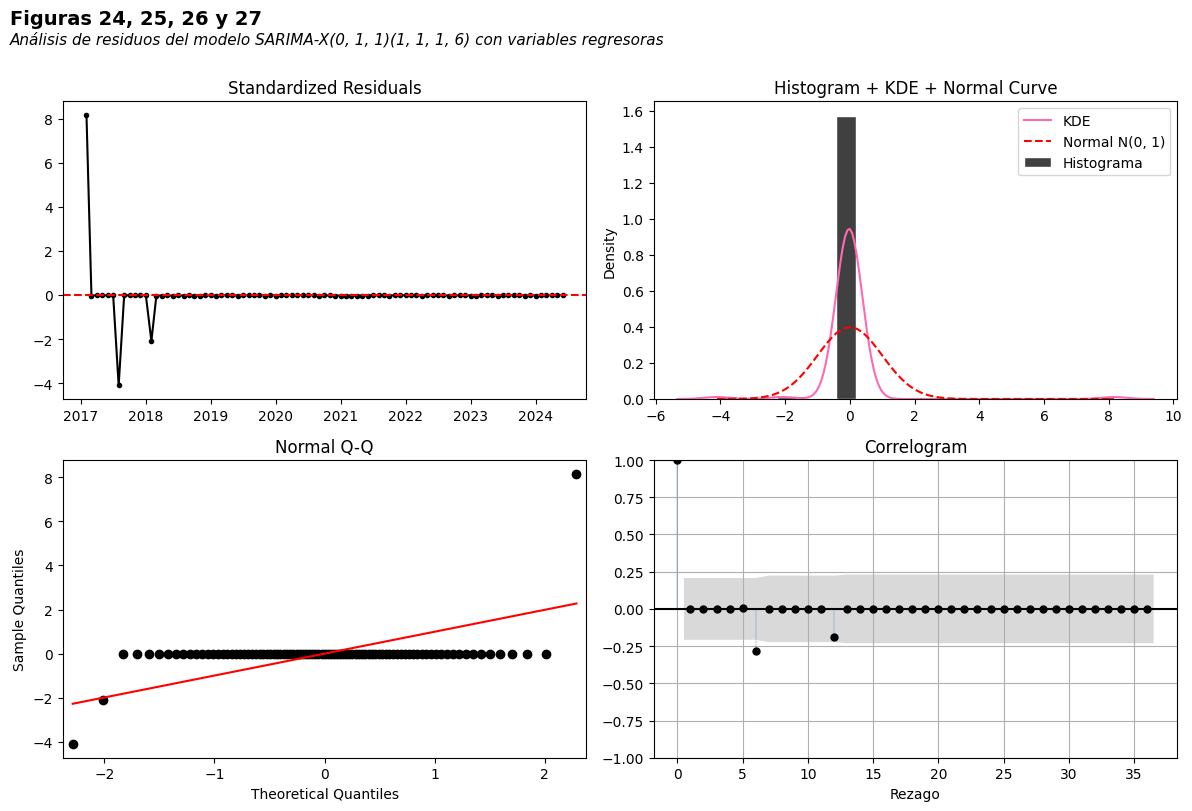

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Residuales estandarizados
axes[0, 0].plot(resid_std_sarimax, color='black', marker='o', markersize=3)
axes[0, 0].axhline(y=0, linestyle='--', color='red')
axes[0, 0].set_title("Standardized Residuals", color='black')
axes[0, 0].tick_params(colors='black')

# Histograma + KDE + Curva Normal
sns.histplot(
    resid_std_sarimax,
    bins=20,
    kde=False,
    color='black',
    edgecolor='white',
    stat="density",
    ax=axes[0, 1],
    label='Histograma'
)
sns.kdeplot(
    resid_std_sarimax,
    color='hotpink',
    ax=axes[0, 1],
    label='KDE'
)
x = np.linspace(resid_std_sarimax.min(), resid_std_sarimax.max(), 100)
axes[0, 1].plot(x, norm.pdf(x, 0, 1), color='red', linestyle='--', label='Normal N(0, 1)')
axes[0, 1].set_title("Histogram + KDE + Normal Curve", color='black')
axes[0, 1].legend()
axes[0, 1].tick_params(colors='black')

# Q-Q plot
qq = qqplot(resid_std_sarimax, line='s', ax=axes[1, 0])
if axes[1, 0].collections:
    dots = axes[1, 0].collections[0]
    dots.set_facecolor('black')
    dots.set_edgecolor('black')
elif len(axes[1, 0].lines) > 1:
    puntos = axes[1, 0].lines[0]
    puntos.set_color('black')
    puntos.set_markerfacecolor('black')
    puntos.set_markeredgecolor('black')
if len(axes[1, 0].lines) > 1:
    linea_teorica = axes[1, 0].lines[1]
    linea_teorica.set_color('red')
axes[1, 0].set_title("Normal Q-Q", color='black')
axes[1, 0].tick_params(colors='black')

# Correlograma
color = 'black'
plot_acf(resid_std_sarimax, ax=axes[1, 1], lags=36, alpha=0.05, color=color)
axes[1, 1].set_title('Correlogram', fontsize=12, color=color)
axes[1, 1].set_xlabel('Rezago')
axes[1, 1].grid(True)
for line in axes[1, 1].lines:
    line.set_color(color)
    line.set_markerfacecolor(color)
    line.set_markeredgecolor(color)
for patch in axes[1, 1].collections:
    patch.set_facecolor(color)
    patch.set_alpha(0.15)
axes[1, 1].tick_params(colors=color)

fig.text(0.01, 0.99, "Figuras 24, 25, 26 y 27", fontsize=14, fontweight='bold', color='black', ha='left')
fig.text(0.01, 0.965, "Análisis de residuos del modelo SARIMA-X(0, 1, 1)(1, 1, 1, 6) con variables regresoras", fontsize=11, style='italic', color='black', ha='left')

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

Predicción


In [47]:
X_test = X_test.replace([np.inf, -np.inf], np.nan).dropna()
y_test = y_test.loc[X_test.index]

n_test = min(len(X_test), len(y_test))

In [48]:
X_test_valid = X_test[['tasa_pf', 'ipc', 'emae']].replace([np.inf, -np.inf], np.nan)
X_test_valid = X_test_valid.fillna(method='bfill').fillna(method='ffill')
fechas_validas = X_test_valid.index.intersection(y_test.index)
fechas_forecast = fechas_validas[-n_test:]
X_test_valid = X_test_valid.loc[fechas_forecast]
y_test_valid = y_test.loc[fechas_forecast]

assert X_test_valid.shape == (n_test, 3), f"❌ Error: X_test_valid.shape={X_test_valid.shape}, esperado (12, 3)"

forecast = resultado_sarimax.get_forecast(steps=n_test, exog=X_test_valid)

log_y_pred = forecast.predicted_mean
y_pred_original = np.exp(log_y_pred)
y_real_original = np.exp(y_test_valid)

log_y_std = forecast.se_mean  # std de la media pronosticada
log_y_upper_1 = log_y_pred + log_y_std
log_y_lower_1 = log_y_pred - log_y_std
log_y_upper_2 = log_y_pred + 2 * log_y_std
log_y_lower_2 = log_y_pred - 2 * log_y_std

y_upper_1 = np.exp(log_y_upper_1)
y_lower_1 = np.exp(log_y_lower_1)
y_upper_2 = np.exp(log_y_upper_2)
y_lower_2 = np.exp(log_y_lower_2)

Métricas de error en escala original


In [49]:
mse_sarimax_6 = mean_squared_error(y_real_original, y_pred_original)
rmse_sarimax_6 = np.sqrt(mse_sarimax_6)
mae_sarimax_6 = mean_absolute_error(y_real_original, y_pred_original)
mape_sarimax_6 = np.mean(np.abs((y_real_original - y_pred_original) / y_real_original)) * 100

print(f"✅ RMSE: ${rmse_sarimax_6:,.0f}")
print(f"✅ MAE : ${mae_sarimax_6:,.0f}")
print(f"✅ MAPE: {mape_sarimax_6:.2f}%")

✅ RMSE: $1,433,821,342,445
✅ MAE : $1,404,824,312,533
✅ MAPE: 8.07%


Visualización


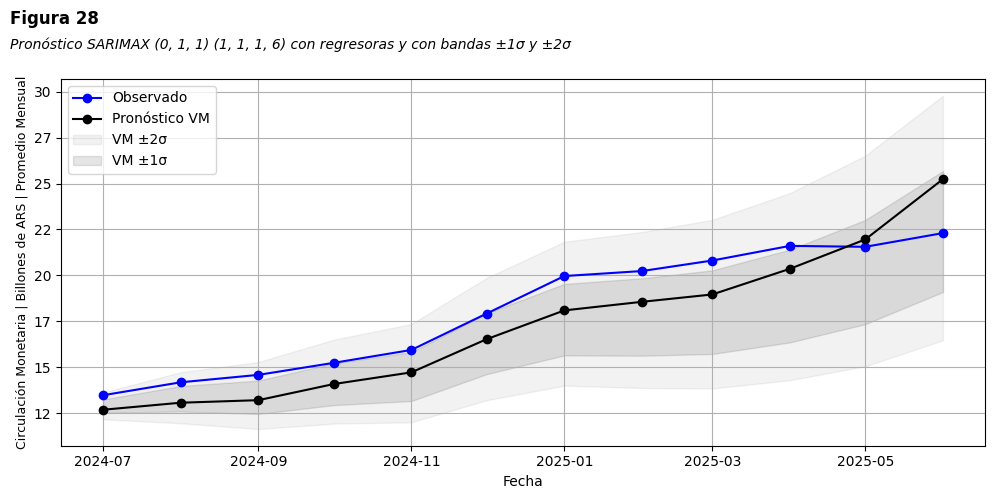

In [50]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(test_original.index, test_original, label='Observado', color='blue', marker='o')
ax.plot(pred_mean_6.index, pred_mean_6, label='Pronóstico VM', color='black', marker='o')
ax.fill_between(test_original.index, pred_lower_2sd, pred_upper_2sd,
                color='black', alpha=0.05, label='VM ±2σ')
ax.fill_between(test_original.index, pred_lower_1sd, pred_upper_1sd,
                color='black', alpha=0.10, label='VM ±1σ')
ax.set_xlabel("Fecha")
ax.set_ylabel("Circulación Monetaria | Billones de ARS | Promedio Mensual", fontsize=9)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x / 1e12)}'))
ax.legend()
ax.grid(True)
fig.text(0.01, 0.96, "Figura 28", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91, "Pronóstico SARIMAX (0, 1, 1) (1, 1, 1, 6) con regresoras y con bandas ±1σ y ±2σ",
         fontsize=10, style='italic', ha='left')
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

Modelo alternativo incluyendo rezagos de 6 y 12 meses como regresoras adicionales.

Entrenamiento del modelo y estimación de sus coeficientes.

In [51]:
y = serie_log

log_tasa = np.log(tasa_pf_mensual)
log_ipc = np.log(ipc_mensual['ipc'])
log_emae = np.log(emae_df['emae'])

X = pd.concat([log_tasa, log_ipc, log_emae], axis=1)
X.columns = ['tasa_pf', 'ipc', 'emae']
X['rezago_6m'] = y.shift(6)
X['rezago_12m'] = y.shift(12)

datos_completos = pd.concat([y, X], axis=1).dropna()
y_clean = datos_completos.iloc[:, 0].astype(float)
X_clean = datos_completos.iloc[:, 1:].astype(float)

y, X = y.align(X, join='inner')

X = X.astype(float)
y = y.astype(float)

datos_completos = pd.concat([y, X], axis=1).dropna()
y = datos_completos.iloc[:, 0]
X = datos_completos.iloc[:, 1:]

n_test = 12
y_train, y_test = y_clean.iloc[:-n_test], y_clean.iloc[-n_test:]
X_train, X_test = X_clean.iloc[:-n_test], X_clean.iloc[-n_test:]

y_train, y_test = y.iloc[:-n_test], y.iloc[-n_test:]
X_train, X_test = X.iloc[:-n_test], X.iloc[-n_test:]

modelo_sarimax_lags = sm.tsa.SARIMAX(
    y_train,
    exog=X_train,
    order=(0, 1, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
)

resultado_lags = modelo_sarimax_lags.fit(disp=False)
resid_lags = resultado_lags.resid
resid_std_lags = (resid_lags - resid_lags.mean()) / resid_lags.std()
print(resultado_lags.summary())

                                 SARIMAX Results                                 
Dep. Variable:     circulacion_monetaria   No. Observations:                   75
Model:                  SARIMAX(0, 1, 1)   Log Likelihood                 162.307
Date:                   Tue, 15 Jul 2025   AIC                           -310.613
Time:                           18:35:49   BIC                           -294.677
Sample:                       02-01-2018   HQIC                          -304.269
                            - 04-01-2024                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tasa_pf       -0.0450      0.048     -0.936      0.349      -0.139       0.049
ipc           -0.0111      0.009     -1.249      0.212      -0.028       0.006
emae           0.0050      0

Diagnóstico de los residuos.

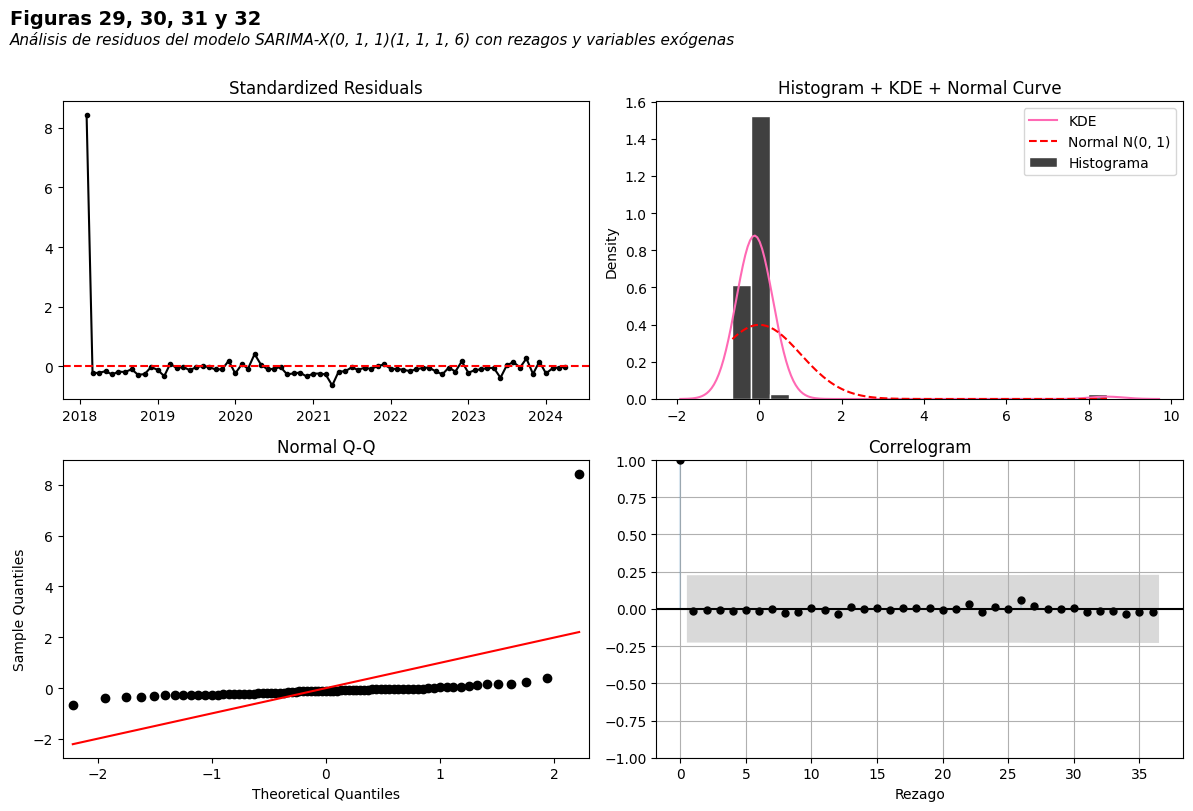

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Residuales estandarizados
axes[0, 0].plot(resid_std_lags, color='black', marker='o', markersize=3)
axes[0, 0].axhline(y=0, linestyle='--', color='red')
axes[0, 0].set_title("Standardized Residuals", color='black')
axes[0, 0].tick_params(colors='black')

# Histograma + KDE + Curva Normal
sns.histplot(
    resid_std_lags,
    bins=20,
    kde=False,
    color='black',
    edgecolor='white',
    stat="density",
    ax=axes[0, 1],
    label='Histograma'
)
sns.kdeplot(
    resid_std_lags,
    color='hotpink',
    ax=axes[0, 1],
    label='KDE'
)
x = np.linspace(resid_std_lags.min(), resid_std_lags.max(), 100)
axes[0, 1].plot(x, norm.pdf(x, 0, 1), color='red', linestyle='--', label='Normal N(0, 1)')
axes[0, 1].set_title("Histogram + KDE + Normal Curve", color='black')
axes[0, 1].legend()
axes[0, 1].tick_params(colors='black')

# Q-Q plot
qq = qqplot(resid_std_lags, line='s', ax=axes[1, 0])
if axes[1, 0].collections:
    dots = axes[1, 0].collections[0]
    dots.set_facecolor('black')
    dots.set_edgecolor('black')
elif len(axes[1, 0].lines) > 1:
    puntos = axes[1, 0].lines[0]
    puntos.set_color('black')
    puntos.set_markerfacecolor('black')
    puntos.set_markeredgecolor('black')
if len(axes[1, 0].lines) > 1:
    linea_teorica = axes[1, 0].lines[1]
    linea_teorica.set_color('red')
axes[1, 0].set_title("Normal Q-Q", color='black')
axes[1, 0].tick_params(colors='black')

# Correlograma
color = 'black'
plot_acf(resid_std_lags, ax=axes[1, 1], lags=36, alpha=0.05, color=color)
axes[1, 1].set_title('Correlogram', fontsize=12, color=color)
axes[1, 1].set_xlabel('Rezago')
axes[1, 1].grid(True)
for line in axes[1, 1].lines:
    line.set_color(color)
    line.set_markerfacecolor(color)
    line.set_markeredgecolor(color)
for patch in axes[1, 1].collections:
    patch.set_facecolor(color)
    patch.set_alpha(0.15)
axes[1, 1].tick_params(colors=color)

# ---------------------- Títulos globales ----------------------
fig.text(0.01, 0.99, "Figuras 29, 30, 31 y 32", fontsize=14, fontweight='bold', color='black', ha='left')
fig.text(
    0.01, 0.965,
    "Análisis de residuos del modelo SARIMA-X(0, 1, 1)(1, 1, 1, 6) con rezagos y variables exógenas",
    fontsize=11,
    style='italic',
    color='black',
    ha='left'
)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

Predicción

In [53]:
X_test = X_test.replace([np.inf, -np.inf], np.nan).dropna()
y_test = y_test.loc[X_test.index]

n_test = min(len(X_test), len(y_test))

columnas_modelo = ['tasa_pf', 'ipc', 'emae', 'rezago_6m', 'rezago_12m']
X_test_valid = X_test[columnas_modelo].replace([np.inf, -np.inf], np.nan)
X_test_valid = X_test_valid.fillna(method='bfill').fillna(method='ffill')
fechas_validas = X_test_valid.index.intersection(y_test.index)
fechas_forecast = fechas_validas[-n_test:]
X_test_valid = X_test_valid.loc[fechas_forecast]
y_test_valid = y_test.loc[fechas_forecast]

assert X_test_valid.shape == (n_test, 5), f"❌ Error: X_test_valid.shape={X_test_valid.shape}, esperado ({n_test}, 5)"

forecast = resultado_lags.get_forecast(steps=n_test, exog=X_test_valid)
log_y_pred = forecast.predicted_mean
log_y_std = forecast.se_mean

y_pred_original = np.exp(log_y_pred)
y_real_original = np.exp(y_test_valid)

log_y_upper_1 = log_y_pred + log_y_std
log_y_lower_1 = log_y_pred - log_y_std
log_y_upper_2 = log_y_pred + 2 * log_y_std
log_y_lower_2 = log_y_pred - 2 * log_y_std

y_upper_1 = np.exp(log_y_upper_1)
y_lower_1 = np.exp(log_y_lower_1)
y_upper_2 = np.exp(log_y_upper_2)
y_lower_2 = np.exp(log_y_lower_2)

Métricas de error en escala original

In [54]:
mse_sarimax_6_12 = mean_squared_error(y_real_original, y_pred_original)
rmse_sarimax_6_12 = np.sqrt(mse_sarimax_6_12)
mae_sarimax_6_12 = mean_absolute_error(y_real_original, y_pred_original)
mape_sarimax_6_12 = np.mean(np.abs((y_real_original - y_pred_original) / y_real_original)) * 100

print(f"✅ RMSE (escala original): {rmse_sarimax_6_12:,.0f}")
print(f"✅ MAE  (escala original): {mae_sarimax_6_12:,.0f}")
print(f"✅ MAPE (escala original): {mape_sarimax_6_12:.2f}%")

✅ RMSE (escala original): 2,661,792,021,393
✅ MAE  (escala original): 2,543,205,582,165
✅ MAPE (escala original): 15.58%


Visualización

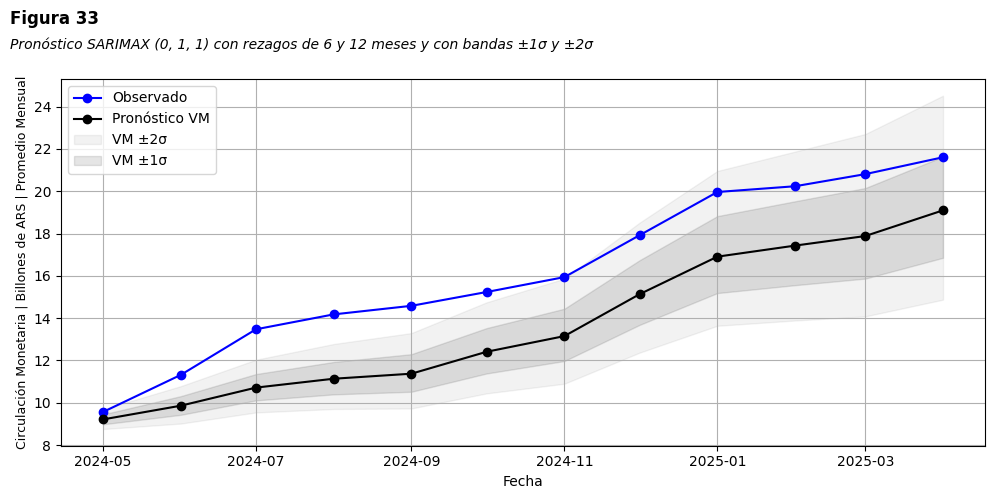

In [55]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(y_real_original.index, y_real_original, label='Observado', color='blue', marker='o')
ax.plot(y_pred_original.index, y_pred_original, label='Pronóstico VM', color='black', marker='o')
ax.fill_between(y_pred_original.index, y_lower_2, y_upper_2, color='black', alpha=0.05, label='VM ±2σ')
ax.fill_between(y_pred_original.index, y_lower_1, y_upper_1, color='black', alpha=0.10, label='VM ±1σ')
ax.set_xlabel("Fecha")
ax.set_ylabel("Circulación Monetaria | Billones de ARS | Promedio Mensual", fontsize=9)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x / 1e12)}'))
ax.legend()
ax.grid(True)
fig.text(0.01, 0.96, "Figura 33", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91,
         "Pronóstico SARIMAX (0, 1, 1) con rezagos de 6 y 12 meses y con bandas ±1σ y ±2σ",
         fontsize=10, style='italic', ha='left')
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

Comparación de métricas de los modelos SARIMA-X

In [56]:
resultados_modelos_sarimax = pd.DataFrame([
    {
        "Modelo": "SARIMA-X (0, 1, 1) (1, 1, 1, 6)",
        "RMSE": f"$ {rmse_sarimax_6:,.0f}",
        "MAE": f"$ {mae_sarimax_6:,.0f}",
        "MAPE (%)": f"{mape_sarimax_6:.2f}%"
    },
    {
        "Modelo": "SARIMA-X (0, 1, 1) + rezagos 6m y 12m",
        "RMSE": f"$ {rmse_sarimax_6_12:,.0f}",
        "MAE": f"$ {mae_sarimax_6_12:,.0f}",
        "MAPE (%)": f"{mape_sarimax_6_12:.2f}%"
    }
])

mostrar_tabla_resultados(
    resultados_modelos_sarimax,
    "<b>Tabla 4</b><br><i>Comparación de desempeño de modelos SARIMA-X</i>",
    nombre_columna="Modelo"
)

,Modelo,RMSE,MAE,MAPE (%)
0,"SARIMA-X (0, 1, 1) (1, 1, 1, 6)","$ 1,433,821,342,445","$ 1,404,824,312,533",8.07%
1,"SARIMA-X (0, 1, 1) + rezagos 6m y 12m","$ 2,661,792,021,393","$ 2,543,205,582,165",15.58%


In [57]:
resultados_modelos_sarima_sarimax = pd.DataFrame([
    {
        "Modelo": "SARIMA (0, 1, 1) (1, 1, 1, 6)",
        "RMSE": f"$ {rmse_6:,.0f}",
        "MAE": f"$ {mae_6:,.0f}",
        "MAPE (%)": f"{mape_6:.2f}%"
    },
    {
        "Modelo": "SARIMA (0, 1, 1) (0, 1, 1, 12)",
        "RMSE": f"$ {rmse_12:,.0f}",
        "MAE": f"$ {mae_12:,.0f}",
        "MAPE (%)": f"{mape_12:.2f}%"
    },
    {
        "Modelo": "SARIMA-X (0, 1, 1) (1, 1, 1, 6)",
        "RMSE": f"$ {rmse_sarimax_6:,.0f}",
        "MAE": f"$ {mae_sarimax_6:,.0f}",
        "MAPE (%)": f"{mape_sarimax_6:.2f}%"
    },
    {
        "Modelo": "SARIMA-X (0, 1, 1) + rezagos 6m y 12m",
        "RMSE": f"$ {rmse_sarimax_6_12:,.0f}",
        "MAE": f"$ {mae_sarimax_6_12:,.0f}",
        "MAPE (%)": f"{mape_sarimax_6_12:.2f}%"
    }
])

mostrar_tabla_resultados(
    resultados_modelos_sarima_sarimax,
    "<b>Tabla 5</b><br><i>Comparación de desempeño de modelos SARIMA y SARIMA-X</i>",
    nombre_columna="Modelo"
)

,Modelo,RMSE,MAE,MAPE (%)
0,"SARIMA (0, 1, 1) (1, 1, 1, 6)","$ 1,543,616,752,305","$ 1,418,923,817,818",7.79%
1,"SARIMA (0, 1, 1) (0, 1, 1, 12)","$ 1,875,118,184,716","$ 1,658,585,862,741",8.96%
2,"SARIMA-X (0, 1, 1) (1, 1, 1, 6)","$ 1,433,821,342,445","$ 1,404,824,312,533",8.07%
3,"SARIMA-X (0, 1, 1) + rezagos 6m y 12m","$ 2,661,792,021,393","$ 2,543,205,582,165",15.58%


In [58]:
resultados_modelos_sarima_sarimax = pd.DataFrame([
    {
        "Modelo": "SARIMA (0, 1, 1) (1, 1, 1, 6)",
        "RMSE": f"$ {rmse_6:,.0f}",
        "MAE": f"$ {mae_6:,.0f}",
        "MAPE (%)": f"{mape_6:.2f}%",
        "AIC": f"{resultado_6.aic:.2f}",
        "BIC": f"{resultado_6.bic:.2f}",
        "HQIC": f"{resultado_6.hqic:.2f}"
    },
    {
        "Modelo": "SARIMA (0, 1, 1) (0, 1, 1, 12)",
        "RMSE": f"$ {rmse_12:,.0f}",
        "MAE": f"$ {mae_12:,.0f}",
        "MAPE (%)": f"{mape_12:.2f}%",
        "AIC": f"{resultado_12.aic:.2f}",
        "BIC": f"{resultado_12.bic:.2f}",
        "HQIC": f"{resultado_12.hqic:.2f}"
    },
    {
        "Modelo": "SARIMA-X (0, 1, 1) (1, 1, 1, 6)",
        "RMSE": f"$ {rmse_sarimax_6:,.0f}",
        "MAE": f"$ {mae_sarimax_6:,.0f}",
        "MAPE (%)": f"{mape_sarimax_6:.2f}%",
        "AIC": f"{resultado_sarimax.aic:.2f}",
        "BIC": f"{resultado_sarimax.bic:.2f}",
        "HQIC": f"{resultado_sarimax.hqic:.2f}"
    },
    {
        "Modelo": "SARIMA-X (0, 1, 1) + rezagos 6m y 12m",
        "RMSE": f"$ {rmse_sarimax_6_12:,.0f}",
        "MAE": f"$ {mae_sarimax_6_12:,.0f}",
        "MAPE (%)": f"{mape_sarimax_6_12:.2f}%",
        "AIC": f"{resultado_lags.aic:.2f}",
        "BIC": f"{resultado_lags.bic:.2f}",
        "HQIC": f"{resultado_lags.hqic:.2f}"
    }
])

mostrar_tabla_resultados(
    resultados_modelos_sarima_sarimax,
    "<b>Tabla 5</b><br><i>Comparación de desempeño de modelos SARIMA y SARIMA-X</i>",
    nombre_columna="Modelo"
)


,Modelo,RMSE,MAE,MAPE (%),AIC,BIC,HQIC
0,"SARIMA (0, 1, 1) (1, 1, 1, 6)","$ 1,543,616,752,305","$ 1,418,923,817,818",7.79%,-312.58,-303.36,-308.90
1,"SARIMA (0, 1, 1) (0, 1, 1, 12)","$ 1,875,118,184,716","$ 1,658,585,862,741",8.96%,-258.50,-252.12,-256.00
2,"SARIMA-X (0, 1, 1) (1, 1, 1, 6)","$ 1,433,821,342,445","$ 1,404,824,312,533",8.07%,-317.88,-301.75,-311.44
3,"SARIMA-X (0, 1, 1) + rezagos 6m y 12m","$ 2,661,792,021,393","$ 2,543,205,582,165",15.58%,-310.61,-294.68,-304.27
